# Predict apartment price

In this phase of the project, we aim to develop a model that forecasts the monthly rent for an apartment, leveraging the available apartment data.

## Imports

In [1]:
# DataFrame, data processing, CSV file I/O (e.g. pd.read_csv)
import os

import pandas as pd
import numpy as np

# Translation
from googletrans import Translator

# Matplot
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Seaborn
import seaborn as sns


# Sklearn
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,mean_absolute_error, mean_squared_error, r2_score 
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

1. Loading the data set

The dataset we are going to be using can be downloaded from Kaggle:
https://www.kaggle.com/datasets/lama122/saudi-arabia-real-estate-aqar

### Decrease datafile size using parquet
Print the dataset size - CSV mode

In [2]:
#function used to calculate size of file
def sizeof_fmt(num, suffix="B"):
    for unit in ("", "K", "M", "G", "T", "P", "E", "Z"):
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0

        
    return f"{num:.1f}Yi{suffix}"

In [3]:
csv_dataset_path = 'datasets/SA_Aqar.csv'
file_stats = os.stat(csv_dataset_path)
print(f'CSV Dataset file size: {sizeof_fmt(file_stats.st_size)}')

CSV Dataset file size: 1.5MB


In [4]:
#load dataset
print("Open file:", csv_dataset_path)

dfM2 = pd.read_csv(csv_dataset_path)

#amount of data
print("Shape: ", dfM2.shape)

Open file: datasets/SA_Aqar.csv
Shape:  (3718, 24)


##Data exploration and cleaning

Here is what our data containes:

**city**: the city where the house is located in<br>
**district**: district where the house is located in<br>
**front**: What is the house front is north, west .. etc<br>
**size**: size in m^2<br>
**property_age**: property age for the house<br>
**bathrooms**: number of bathrooms<br>
**livingrooms**: number of living rooms<br>
**kitchen**: show whether the house has a kitchen or not<br>
**garage**: show whether the house has a garage or not<br>
**driver_room**: show whether the house has a driver_room or not<br>
**maid_room**: show whether the house has a maid_room or not<br>
**furnished**: show whether the house is furnished or not<br>
**ac**: show whether the house has an air conditioning or not<br>
**roof**: show whether the house has a space for a roof on top or not<br>
**pool**: show whether the house has a pool or not<br>
**frontyard**: show whether the house has a front yard or not<br>
**basement**: show whether the house has a basement or not<br>
**duplex**: show whether the house is a duplex or not<br>
**stairs**: show whether the house has stairs or not<br>
**elevator**: show whether the house has an elevator or not<br>
**fireplace**: show whether the house has a fireplace or not<br>
**price: show the price of the house**<br>
**details**: shows any additional details from the house owner about the house<br>

Lets take a sneak peek at what our data looks like, we can see the columns as explained above.

In [5]:
dfM2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3718 entries, 0 to 3717
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          3718 non-null   object
 1   district      3718 non-null   object
 2   front         3718 non-null   object
 3   size          3718 non-null   int64 
 4   property_age  3718 non-null   int64 
 5   bedrooms      3718 non-null   int64 
 6   bathrooms     3718 non-null   int64 
 7   livingrooms   3718 non-null   int64 
 8   kitchen       3718 non-null   int64 
 9   garage        3718 non-null   int64 
 10  driver_room   3718 non-null   int64 
 11  maid_room     3718 non-null   int64 
 12  furnished     3718 non-null   int64 
 13  ac            3718 non-null   int64 
 14  roof          3718 non-null   int64 
 15  pool          3718 non-null   int64 
 16  frontyard     3718 non-null   int64 
 17  basement      3718 non-null   int64 
 18  duplex        3718 non-null   int64 
 19  stairs

In [6]:
dfM2.head()

city         district front  size  property_age  bedrooms  bathrooms  \
0   الرياض       حي العارض   شمال   250             0         5          5   
1   الرياض     حي القادسية   جنوب   370             0         4          5   
2   الرياض     حي القادسية   جنوب   380             0         4          5   
3   الرياض     حي المعيزلة    غرب   250             0         5          5   
4   الرياض       حي العليا    غرب   400            11         7          5   

   livingrooms  kitchen  garage  ...  roof  pool  frontyard  basement  duplex  \
0            1        1       1  ...     0     0          1         0       1   
1            2        1       1  ...     0     0          1         0       0   
2            1        1       1  ...     1     0          1         0       0   
3            3        0       1  ...     0     0          1         0       0   
4            2        1       1  ...     1     0          1         0       1   

   stairs  elevator  fireplace  price  \
0       1         0          0  80000   
1       1         0          0  60000   
2       1         0          0  60000   
3       0         0          0  55000   
4       1         0          0  70000   

                                             details  
0  للايجار فيلا دبلكس في موقع ممتاز جدا بالقرب من...  
1  *** فيلا درج مع الصالة جديدة ***\n\nعبارة عن م...  
2  فيلا للايجار درج داخلي مشب خارجي مجلس مقلط وصا...  
3  فيلا للايجار        جديده لن تستخدم          ش...  
4  فيلا للايجار حي العليا \n\nالارضي مجالس وغرفتي...  

[5 rows x 24 columns]

In [7]:
def get_info(_column, df):
    column_obj = eval(f'df.{_column}')
    print(f'min  of {_column} = {column_obj.min()}')
    print(f'max  of {_column} = {column_obj.max()}')
    print(f'mean of {_column} = {column_obj.mean()}')
    print(f'sdv  of {_column} = {column_obj.std()}')
    
    
def print_info(df: pd.DataFrame):
    numeric_columns = [var for var in df.select_dtypes(include=np.number) if len(df[var].value_counts()) > 2]
    for column in  numeric_columns:
        get_info(column, df)
        print()
        
#print_info(dfM2)

dfM2.describe()

size  property_age     bedrooms    bathrooms  livingrooms  \
count   3718.000000   3718.000000  3718.000000  3718.000000  3718.000000   
mean     390.968531      5.064820     5.083916     4.606509     2.243948   
std     1565.056135      7.590427     1.230040     0.703449     0.916436   
min        1.000000      0.000000     1.000000     1.000000     1.000000   
25%      280.000000      0.000000     4.000000     4.000000     2.000000   
50%      330.000000      2.000000     5.000000     5.000000     2.000000   
75%      400.000000      7.000000     6.000000     5.000000     3.000000   
max    95000.000000     36.000000     7.000000     5.000000     5.000000   

           kitchen       garage  driver_room    maid_room    furnished  \
count  3718.000000  3718.000000  3718.000000  3718.000000  3718.000000   
mean      0.909360     0.802044     0.495697     0.795320     0.123453   
std       0.287135     0.398512     0.500049     0.403522     0.329001   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     1.000000     0.000000   
50%       1.000000     1.000000     0.000000     1.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                ac         roof         pool    frontyard     basement  \
count  3718.000000  3718.000000  3718.000000  3718.000000  3718.000000   
mean      0.560785     0.521517     0.162453     0.802582     0.034158   
std       0.496358     0.499604     0.368915     0.398104     0.181660   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     1.000000     0.000000   
50%       1.000000     1.000000     0.000000     1.000000     0.000000   
75%       1.000000     1.000000     0.000000     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            duplex       stairs     elevator    fireplace         price  
count  3718.000000  3718.000000  3718.000000  3718.000000  3.718000e+03  
mean      0.499462     0.814416     0.080958     0.181280  8.738797e+04  
std       0.500067     0.388823     0.272807     0.385302  7.063470e+04  
min       0.000000     0.000000     0.000000     0.000000  1.000000e+03  
25%       0.000000     1.000000     0.000000     0.000000  5.500000e+04  
50%       0.000000     1.000000     0.000000     0.000000  7.000000e+04  
75%       1.000000     1.000000     0.000000     0.000000  1.000000e+05  
max       1.000000     1.000000     1.000000     1.000000  1.700000e+06

Check for NULL values in our data

In [8]:
# Checking null values
null_count = dfM2.isnull().sum()

# Calculate the percentage of missing values
null_percentage = (null_count / len(dfM2)) * 100

# Create a DataFrame to display the results
missing_data_summary = pd.DataFrame({
    'Column': null_count.index,
    'Count': null_count.values,
    'Percentage': null_percentage.values
})

# Print the summary
print(missing_data_summary)


          Column  Count  Percentage
0           city      0    0.000000
1       district      0    0.000000
2          front      0    0.000000
3           size      0    0.000000
4   property_age      0    0.000000
5       bedrooms      0    0.000000
6      bathrooms      0    0.000000
7    livingrooms      0    0.000000
8        kitchen      0    0.000000
9         garage      0    0.000000
10   driver_room      0    0.000000
11     maid_room      0    0.000000
12     furnished      0    0.000000
13            ac      0    0.000000
14          roof      0    0.000000
15          pool      0    0.000000
16     frontyard      0    0.000000
17      basement      0    0.000000
18        duplex      0    0.000000
19        stairs      0    0.000000
20      elevator      0    0.000000
21     fireplace      0    0.000000
22         price      0    0.000000
23       details     80    2.151694


We can see that the only column with missing values ​​is **details** (~2%)

In [9]:
binary_columns = [var for var in dfM2.select_dtypes(include=np.number) if len(dfM2[var].value_counts()) == 2]

for column_name in binary_columns:
    print(f"\n{column_name}")
    

    value_counts = dfM2[column_name].value_counts()
    total_count = len(dfM2[column_name])
    percentages = (value_counts / total_count) * 100
    
    for value, count, percentage in zip(value_counts.index, value_counts.values, percentages.values):
        print(f"{value}: Count={count}, Percentage={percentage:.2f}%")



kitchen
1: Count=3381, Percentage=90.94%
0: Count=337, Percentage=9.06%

garage
1: Count=2982, Percentage=80.20%
0: Count=736, Percentage=19.80%

driver_room
0: Count=1875, Percentage=50.43%
1: Count=1843, Percentage=49.57%

maid_room
1: Count=2957, Percentage=79.53%
0: Count=761, Percentage=20.47%

furnished
0: Count=3259, Percentage=87.65%
1: Count=459, Percentage=12.35%

ac
1: Count=2085, Percentage=56.08%
0: Count=1633, Percentage=43.92%

roof
1: Count=1939, Percentage=52.15%
0: Count=1779, Percentage=47.85%

pool
0: Count=3114, Percentage=83.75%
1: Count=604, Percentage=16.25%

frontyard
1: Count=2984, Percentage=80.26%
0: Count=734, Percentage=19.74%

basement
0: Count=3591, Percentage=96.58%
1: Count=127, Percentage=3.42%

duplex
0: Count=1861, Percentage=50.05%
1: Count=1857, Percentage=49.95%

stairs
1: Count=3028, Percentage=81.44%
0: Count=690, Percentage=18.56%

elevator
0: Count=3417, Percentage=91.90%
1: Count=301, Percentage=8.10%

fireplace
0: Count=3044, Percentage=81

In order to organize our data we want to

   1. erase irrelevent attributes
   2. erase or fill in missing values

However, prior to proceeding, and to facilitate comprehension, we will engage in translation tasks

In [10]:
to_replace = {"شمال": "north", "جنوب": "south", "غرب": "west","شرق":"east", "شمال شرقي":"northeast","جنوب شرقي":"south east"
             ,"3 شوارع":"street", "جنوب غربي":"southwest","شمال غربي":"northwest","4 شوارع":"street",  }

dfM2.replace(to_replace=to_replace, inplace=True)

dfM2.head()

city         district  front  size  property_age  bedrooms  bathrooms  \
0   الرياض       حي العارض   north   250             0         5          5   
1   الرياض     حي القادسية   south   370             0         4          5   
2   الرياض     حي القادسية   south   380             0         4          5   
3   الرياض     حي المعيزلة    west   250             0         5          5   
4   الرياض       حي العليا    west   400            11         7          5   

   livingrooms  kitchen  garage  ...  roof  pool  frontyard  basement  duplex  \
0            1        1       1  ...     0     0          1         0       1   
1            2        1       1  ...     0     0          1         0       0   
2            1        1       1  ...     1     0          1         0       0   
3            3        0       1  ...     0     0          1         0       0   
4            2        1       1  ...     1     0          1         0       1   

   stairs  elevator  fireplace  price  \
0       1         0          0  80000   
1       1         0          0  60000   
2       1         0          0  60000   
3       0         0          0  55000   
4       1         0          0  70000   

                                             details  
0  للايجار فيلا دبلكس في موقع ممتاز جدا بالقرب من...  
1  *** فيلا درج مع الصالة جديدة ***\n\nعبارة عن م...  
2  فيلا للايجار درج داخلي مشب خارجي مجلس مقلط وصا...  
3  فيلا للايجار        جديده لن تستخدم          ش...  
4  فيلا للايجار حي العليا \n\nالارضي مجالس وغرفتي...  

[5 rows x 24 columns]

# Data visualization

A brief explanation of **Skewness** and **Kurtosis** 

**Skewne** ess measures the asymmetry of a dataset's distributon.

    Positive Skewness (Right-skewed): Majority of data on the left, tail on the right. Ideal range: +0.5 to+2.0.

    Negative Skewness (Left-skewed): Majority of data on the right, tail on the left. Ideal range: -2.0 to -0.5.
**Kurtosis** measures the tails of a distribution in relation o its peak.

    Leptokurtic (High Kurtosis): Heavy tails and a sharp peak. Indicates outliers. Ideal range:+1.5 to +3.0.

    Mesokurtic (Normal Kurtosis): Tails and peak similar to a normal distribution. Ideal rang: -1.5 to +1.5.

    Platykurtic (Low Kurtosis): Light tails and a flat peak. Fewer outliers. Ideal range: -3.0 to -1.5.

These measures help us select appropriate statistical methods and models and detect outliers.

Skewness: 7.690328
Kurtosis: 118.677936


<Figure size 800x600 with 0 Axes>

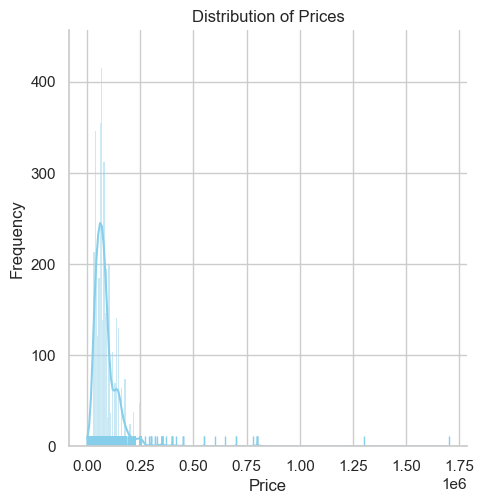

In [11]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.displot(dfM2['price'], kde=True, color='skyblue', rug=True)

plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Skewness and kurtosis
print("\033[1mSkewness:\033[0m %f" % dfM2['price'].skew())
print("\033[1mKurtosis:\033[0m %f" % dfM2['price'].kurt())

plt.show()

**Skewness**
        A skewness value of 7.69 indicates that the distribution is highly positively skewed (the right tail of the distribution is longer or fatter            than the left tail, and the majority of the data points are concentrated on the left side).

**Kurtosis**
        A kurtosis value of 118.68 indicates that the distribution has very heavy tails.
        This means that the price has more extreme values in the tails compared to a normal distribution.

**Analysis**
    The positive skewness suggests that there are a few data points with very high values that are pulling the mean and the right tail of the               distribution.
    The high positive kurtosis indicates the presence of outliers or extreme values in the dataset, contributing to heavy tails.
    Both skewness and kurtosis are indicative of a distribution that is not symmetric and has a concentration of data points on one side with a long        tail on the other.

Skewness: 59.479436
Kurtosis: 3595.511080


<Figure size 800x600 with 0 Axes>

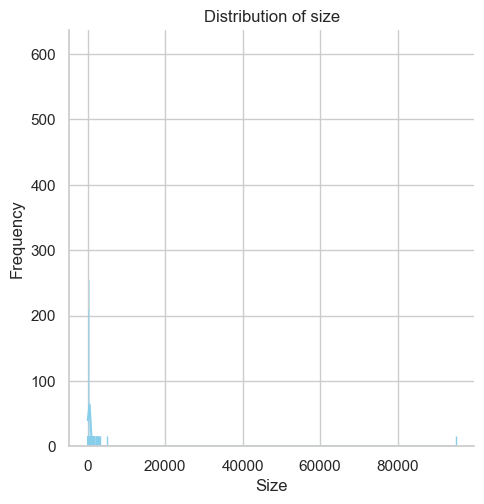

In [12]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.displot(dfM2['size'], kde=True, color='skyblue', rug=True)

plt.title('Distribution of size')
plt.xlabel('Size')
plt.ylabel('Frequency')

# Skewness and kurtosis
print("Skewness: %f" % dfM2['size'].skew())
print("Kurtosis: %f" % dfM2['size'].kurt())

plt.show()

**Skewness**
        The skewness value of 59.48 is very high.
        Positive skewness implies a long tail on the right side of the distribution.
        In this case, the majority of the data points are concentrated on the left side, and there are a few data points with very high values that are         pulling the mean to the right.

**Kurtosis**
        The kurtosis value of 3595.51 is exceptionally high.
        High positive kurtosis indicates extremely heavy tails and a high concentration of data points around the mean.
        The distribution has an excessive number of outliers, and the tails extend far beyond what would be expected in a normal distribution.

**Analysis**
        The extremely high skewness and kurtosis values suggest a distribution that is highly non-normal and heavily influenced by extreme values.
        The variable 'size' likely has a few data points with exceptionally large values, contributing to the observed distribution.

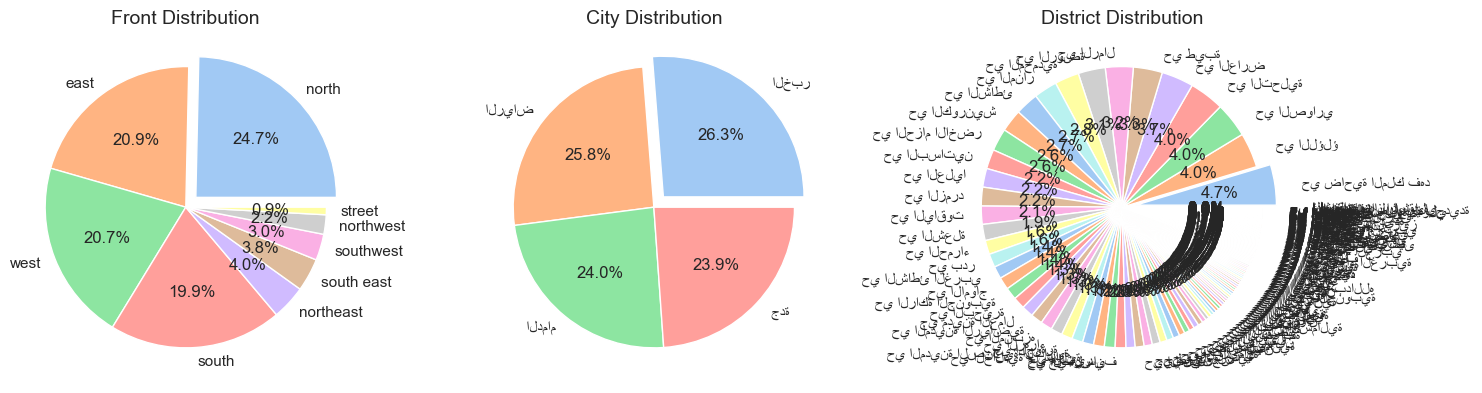

In [13]:
sns.set(style="whitegrid")

columns_to_plot = ['front', 'city', 'district']

colors = sns.color_palette("pastel")

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(15, 5))

for i, column in enumerate(columns_to_plot):
    # Get category counts
    category_counts = dfM2[column].value_counts(normalize=True)
    
    explode = [0.1 if j == 0 else 0 for j in range(len(category_counts))]
    
    axes[i].pie(category_counts, autopct='%1.1f%%', labels=category_counts.index, colors=colors, explode=explode)
    
    axes[i].set_title(f'{column.capitalize()} Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [14]:
num_districts = dfM2['district'].nunique()
print(f"Note the district has {num_districts} different values")


Note the district has 174 different values


Skewness: 2.011501
Kurtosis: 3.870958


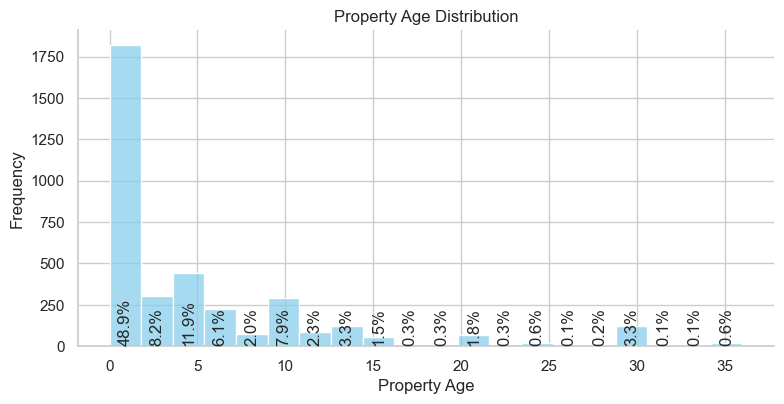

In [15]:
sns.set(style="whitegrid")

sns.displot(dfM2['property_age'], height=4, aspect=2, kde=False, bins=20, color='skyblue')

skewness = dfM2['property_age'].skew()
kurtosis = dfM2['property_age'].kurt()
print("\033[1mSkewness:\033[0m %f" % skewness)
print("\033[1mKurtosis:\033[0m %f" % kurtosis)

counts, bin_edges, _ = plt.hist(dfM2['property_age'], bins=20, alpha=0)  # Get bin counts and edges
for i, bin_edge in enumerate(bin_edges[:-1]):
    count = counts[i]
    percentage = count / len(dfM2['property_age']) * 100
    plt.annotate(f'{percentage:.1f}%', xy=(bin_edge + (bin_edges[i + 1] - bin_edge) / 2, 0),
                 ha='center', va='bottom', rotation=90)

plt.xlabel('Property Age')
plt.ylabel('Frequency')
plt.title('Property Age Distribution')

plt.show()

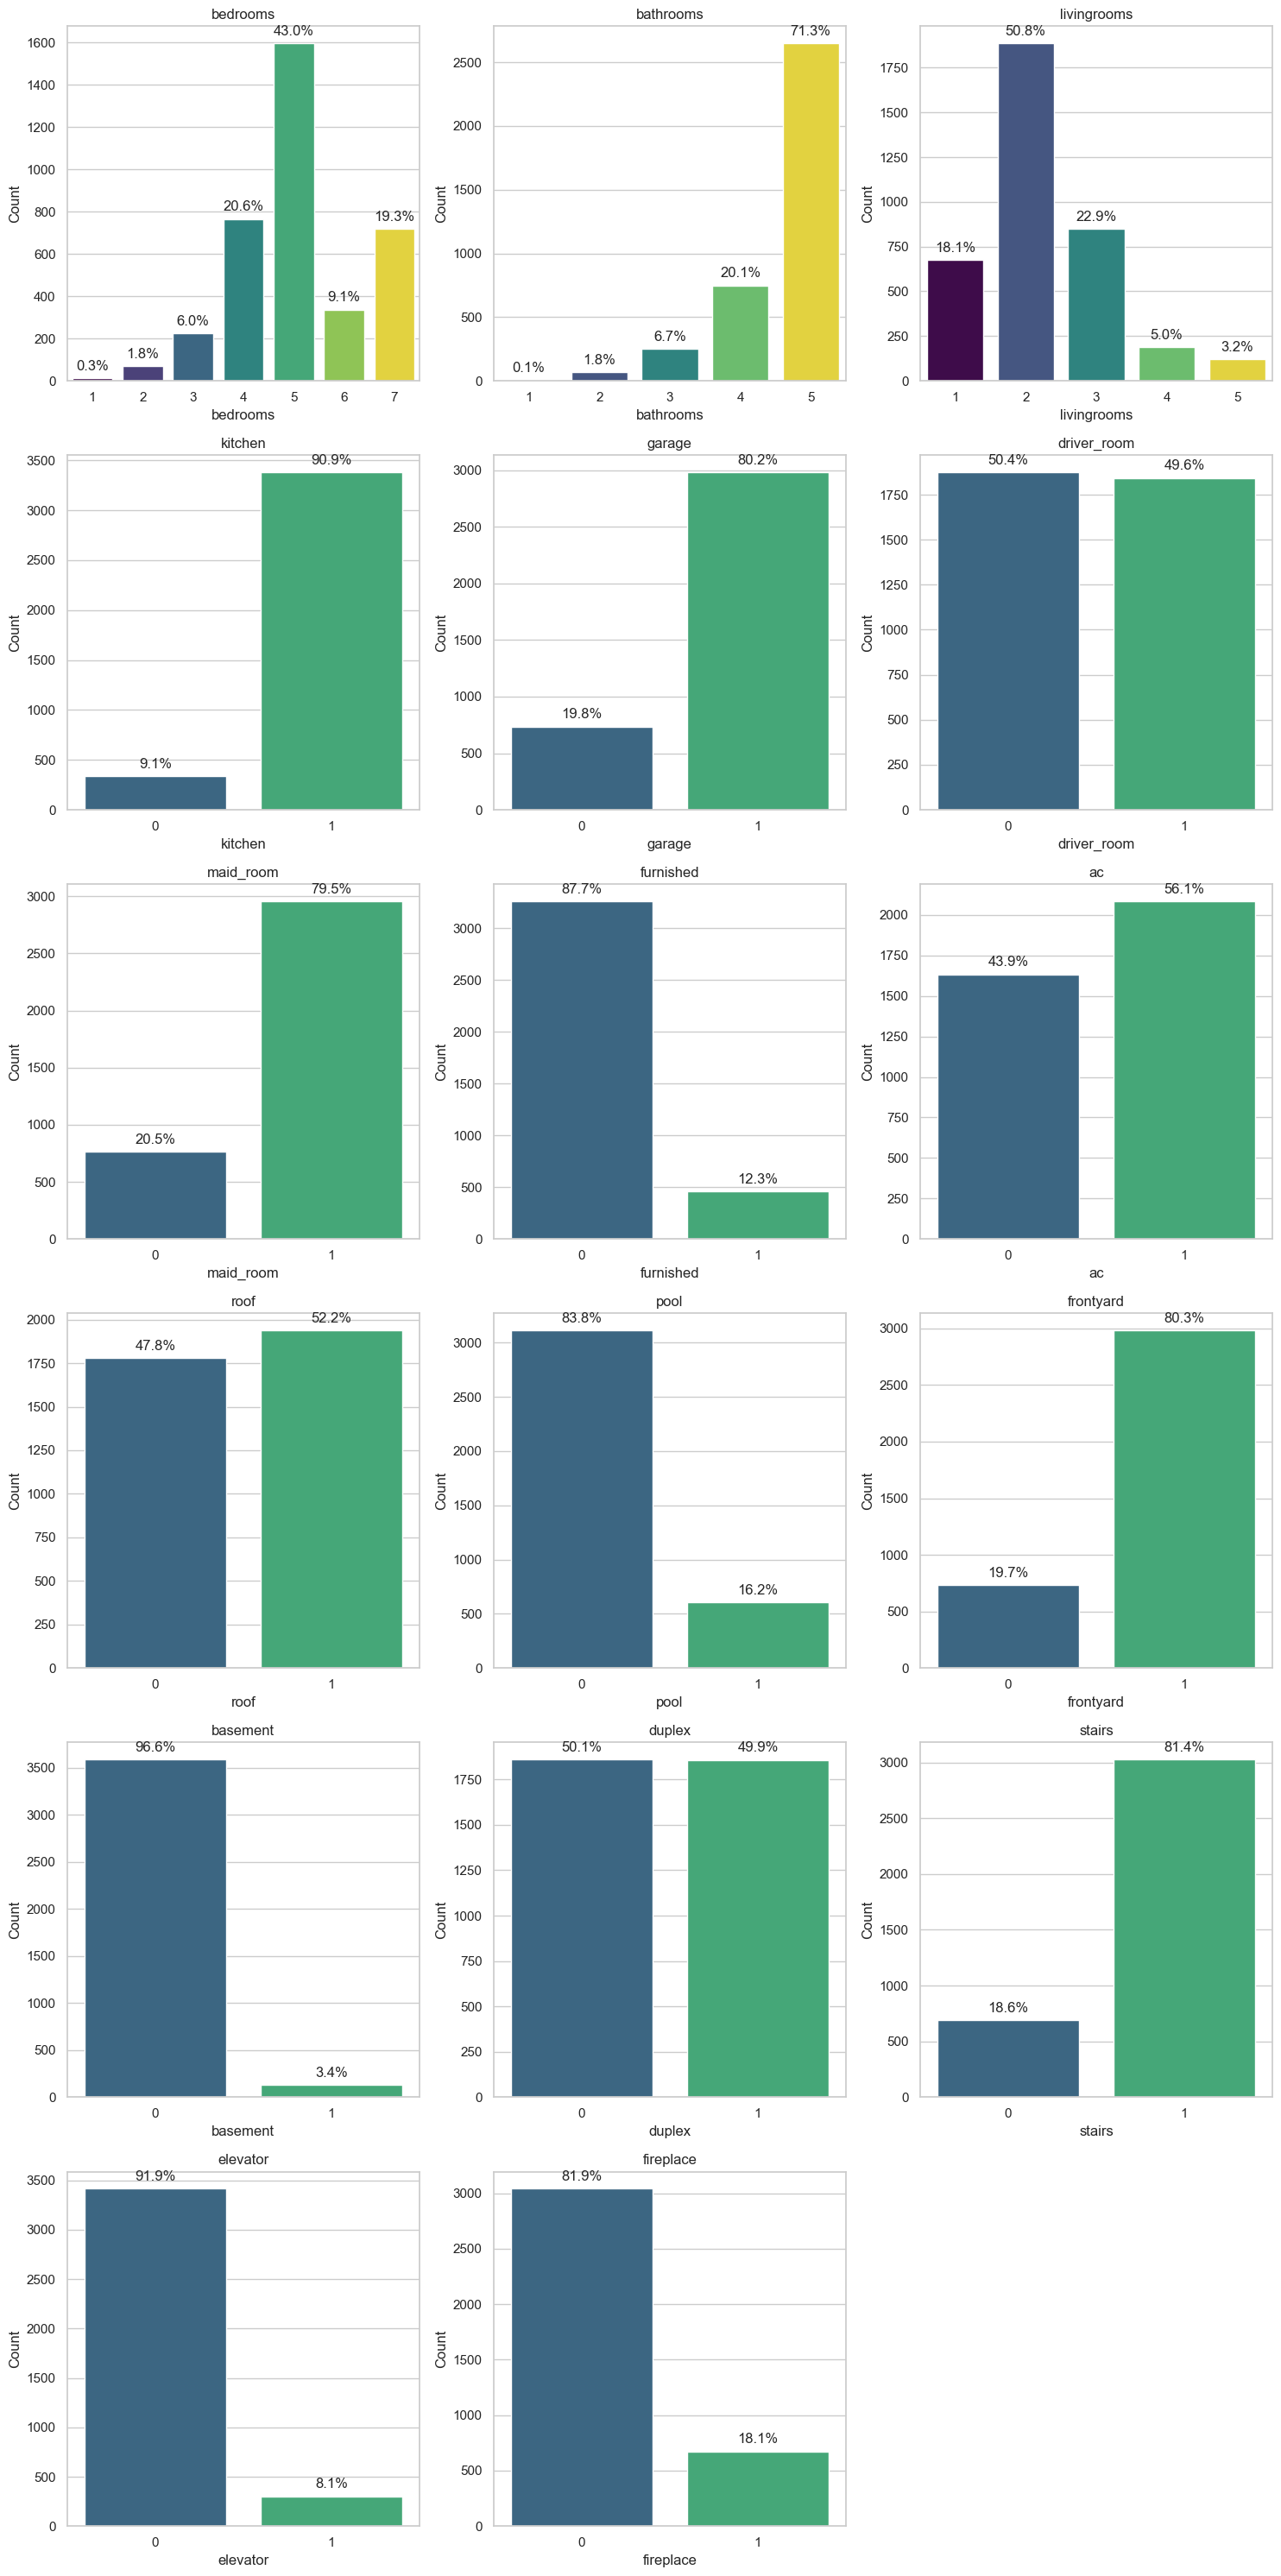

In [16]:
columns_to_plot = [col for col in dfM2.select_dtypes(include='number') if dfM2[col].nunique() < 10]

num_plots = len(columns_to_plot)
num_cols = min(num_plots, 3)
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for idx, column in enumerate(columns_to_plot):
    row_idx = idx // num_cols
    col_idx = idx % num_cols
    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]

    sns.countplot(data=dfM2, x=column, ax=ax, palette='viridis', hue=column, legend=False)

    total_count = len(dfM2[column])
    for p in ax.patches:
        percentage = p.get_height() / total_count * 100
        ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

for i in range(num_plots, num_rows * num_cols):
    if num_rows > 1:
        fig.delaxes(axes[i // num_cols, i % num_cols])
    else:
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Scatter and density plots:

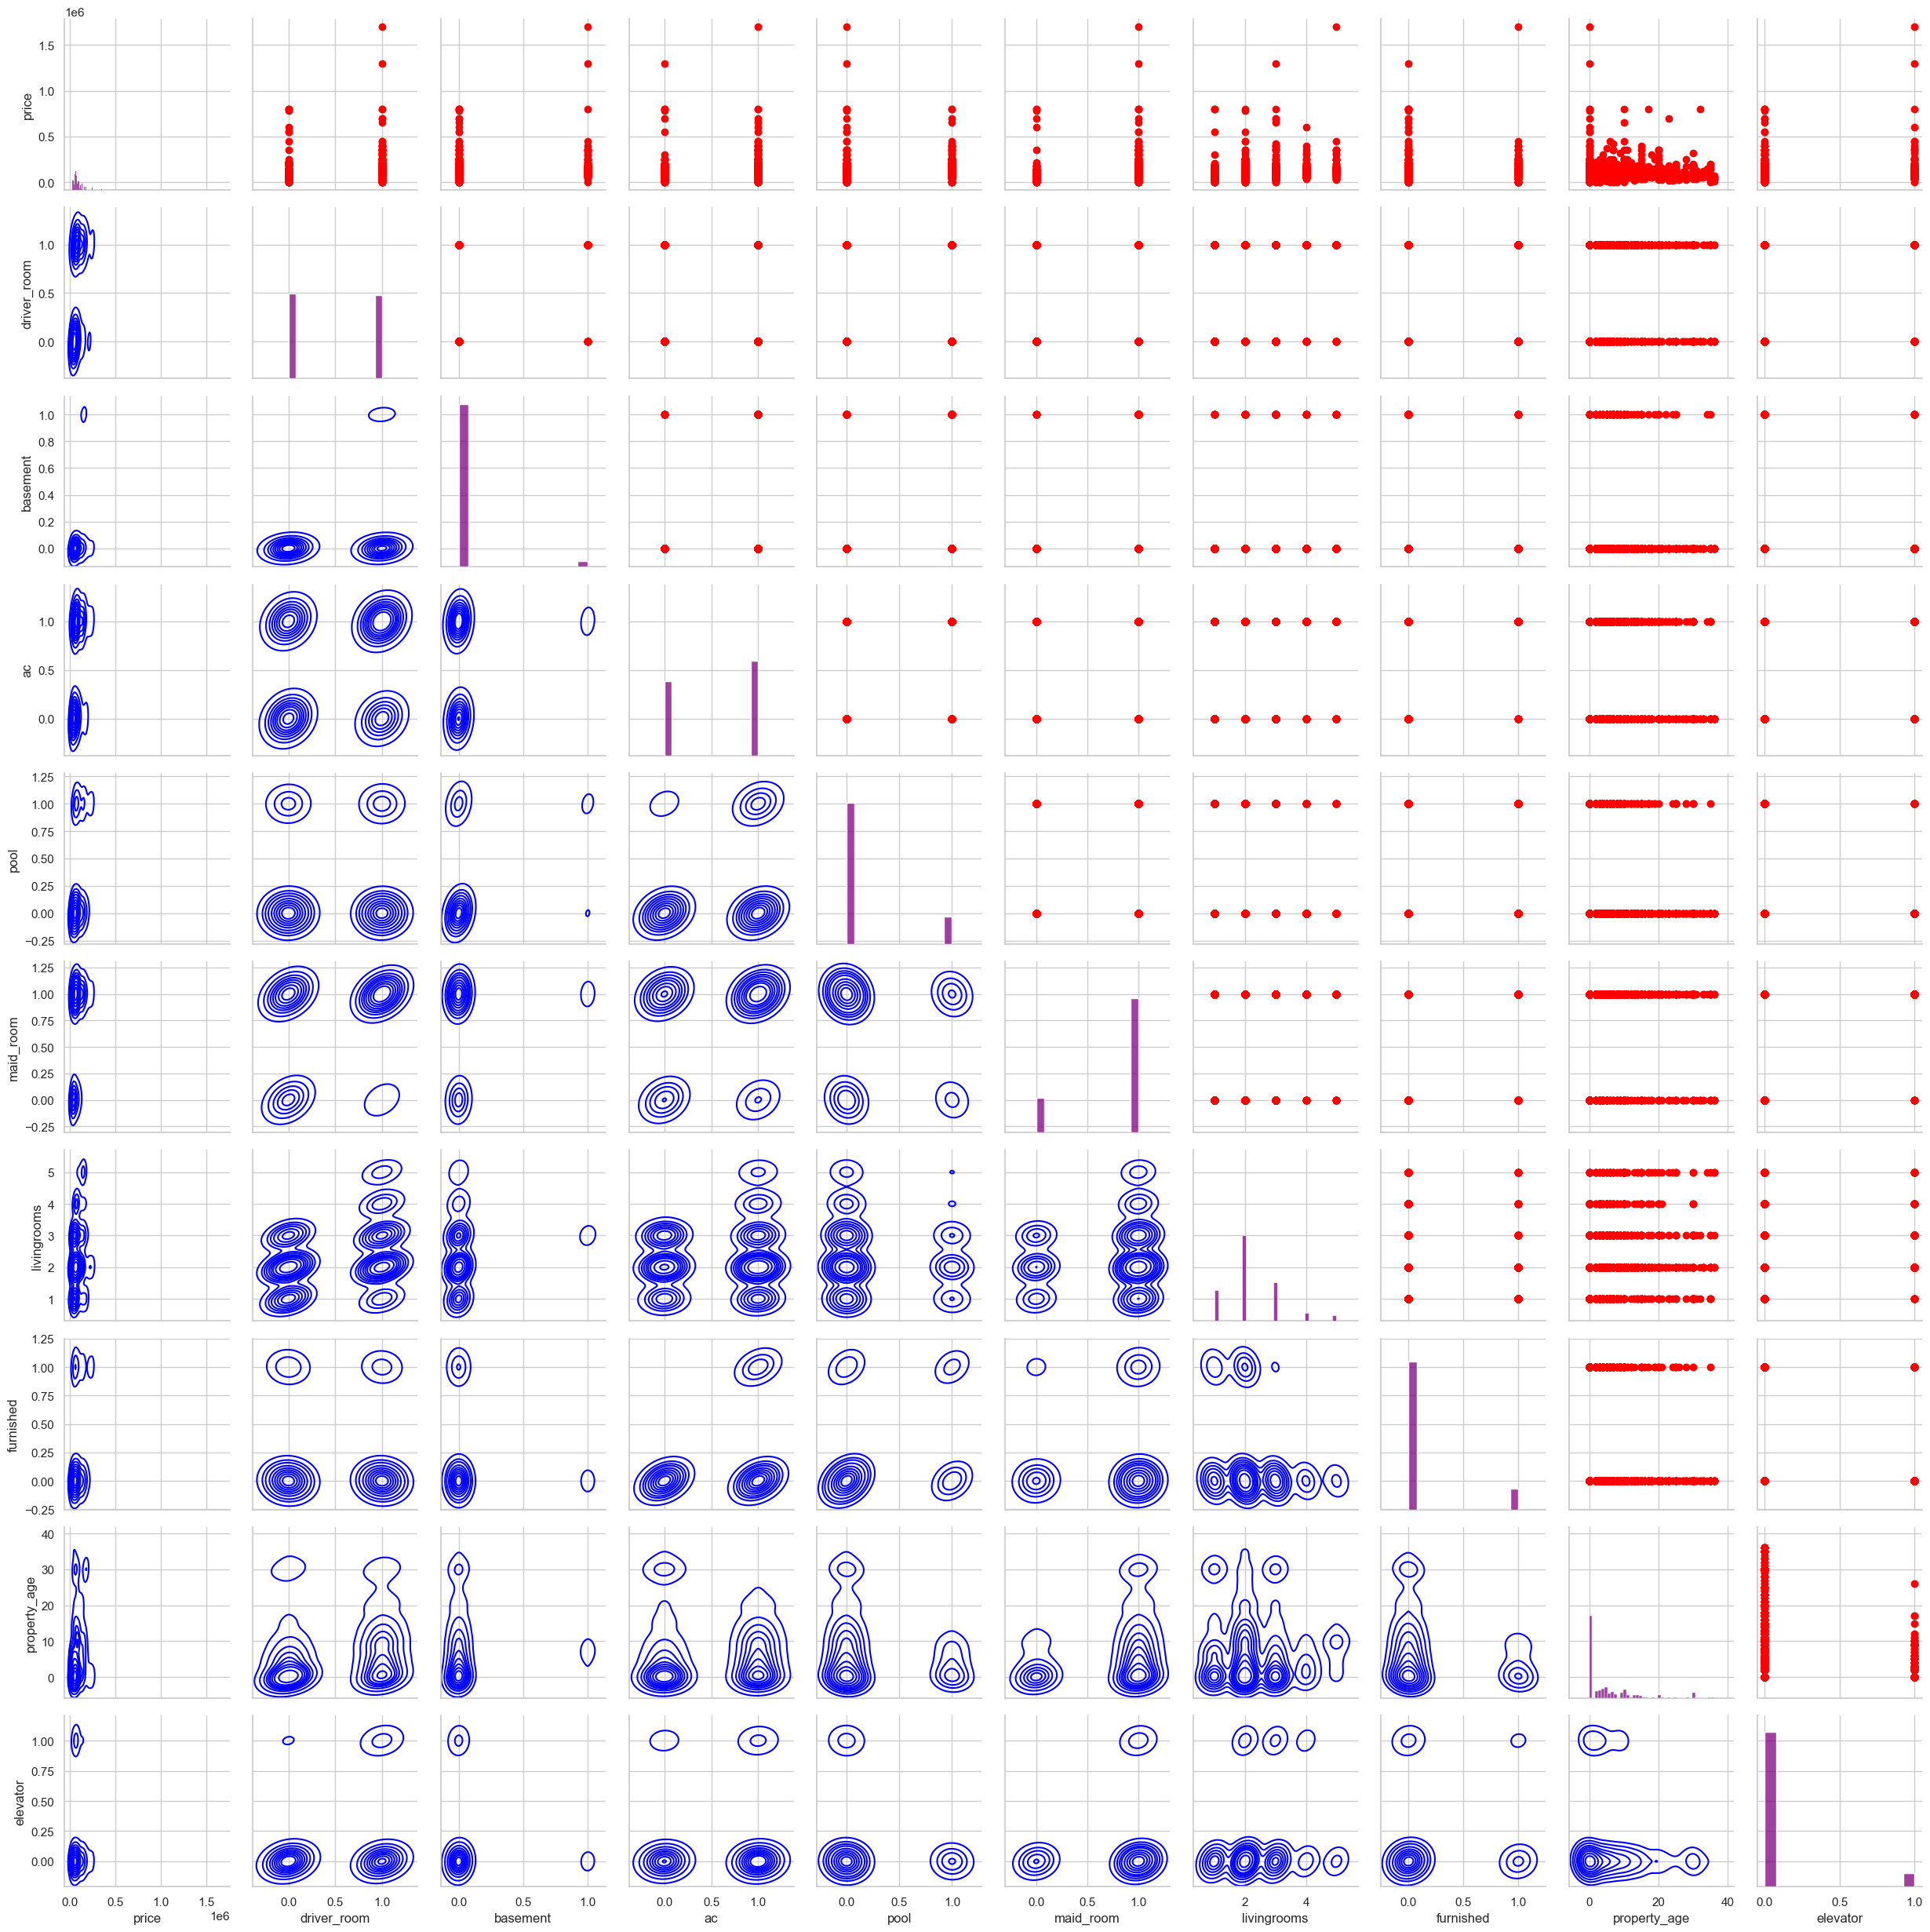

In [17]:
numeric_columns = dfM2.select_dtypes(include=['number']).columns
cor = dfM2[numeric_columns].corr()

strong_attributes = cor.nlargest(10, 'price')['price'].index

g = sns.PairGrid(data=dfM2[strong_attributes])
g.map_diag(sns.histplot, color='purple')
g.map_upper(plt.scatter, color='red')
g.map_lower(sns.kdeplot, color='blue')

plt.show()

# EDA - Exploratory Data Analysis

**In this section we will explore and analyze our data, clean and prepare it, detect outliers, and try to find the features that are most correlated to our target price, and have the most effect on it**

## Drop columns

Since the wanted destination is Amsterdam, we can ignore the 4 cities mapped in our data and the district, in addition we have no possibility to get information from the "details" column (due to too many words in Arabs we cannot use googletrans module), so we will drop that as well

In [18]:
dfM2.drop(columns=['details','district','city'], axis=1 ,inplace=True)

## Correlation

We will now assess the correlation between various features and our target variable - price. To facilitate this analysis, we will convert categorical text representations into corresponding numeric categories.

In [19]:
to_replace = {"north":1, "south":2,"west":3,"east":4,"northeast":5,"south east":6 , "southwest":7,"northwest":8,"street":9}
dfM2.replace(to_replace=to_replace, inplace=True)

<Axes: >

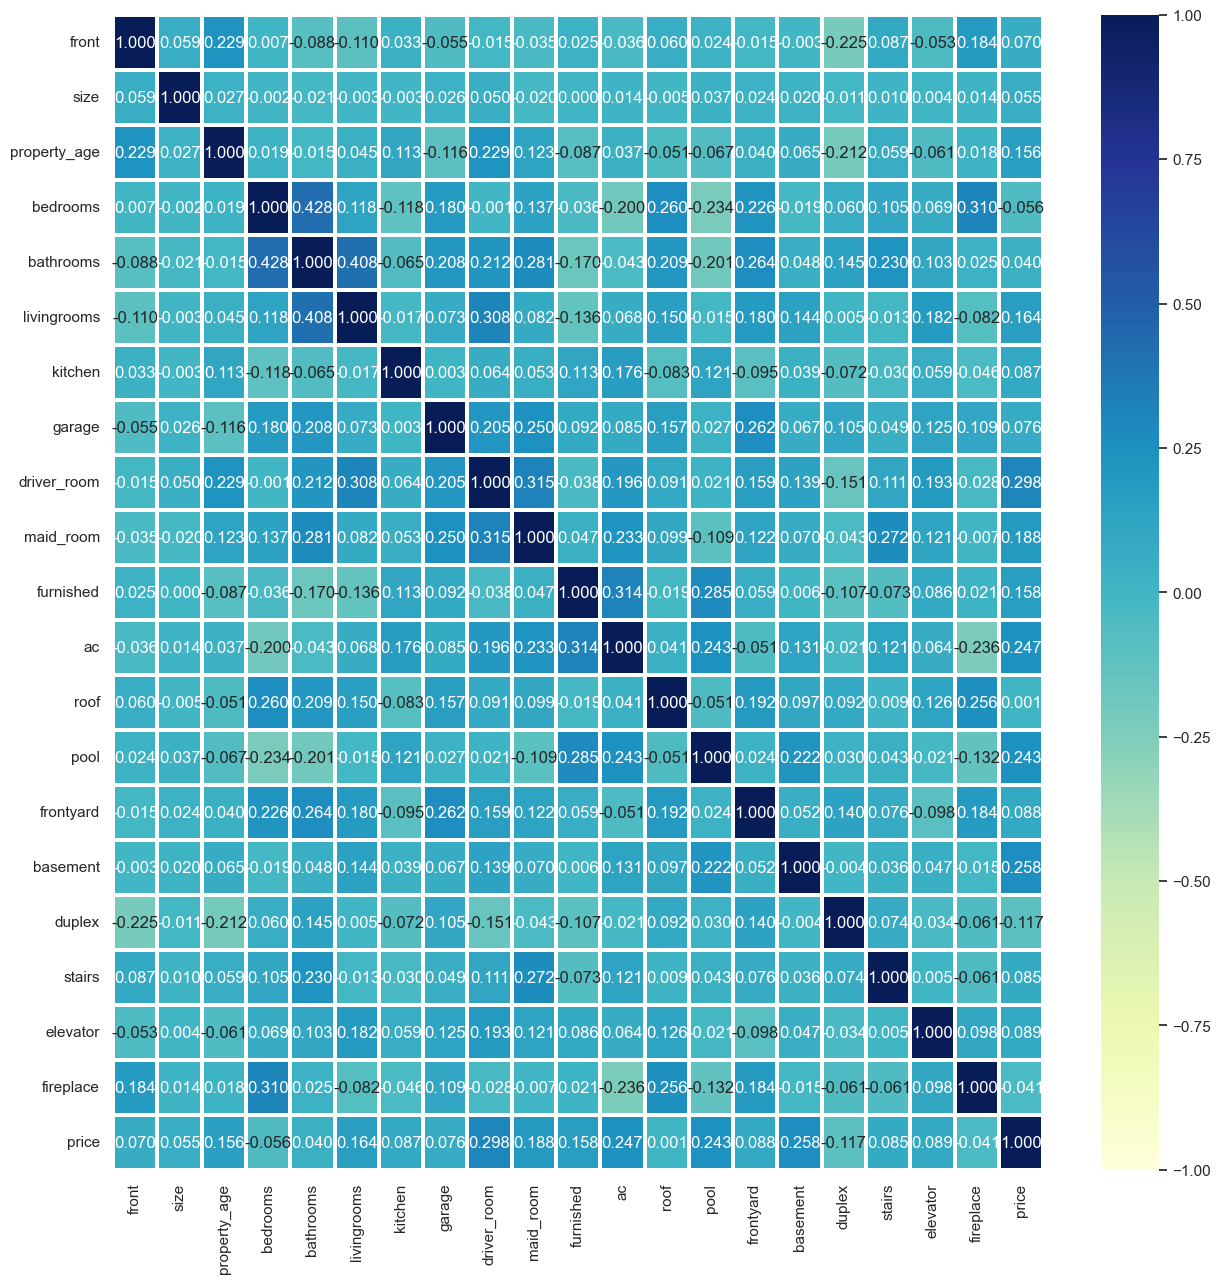

In [20]:
# heatmap of correlation among various attributes
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(dfM2.corr(numeric_only=True), cmap='YlGnBu', annot=True, lw=1.5, fmt='.3f', vmin=-1, vmax=1)

### Key Observations:
**Size and Price:**
            The 'size' variable has a moderately positive correlation with 'price' (0.32). This suggests that, on average, larger properties tend to have higher prices.
            
**Bedrooms, Bathrooms, Livingrooms, and Kitchen:**
            'Bedrooms' and 'bathrooms' show positive correlations with 'size', which is expected.
            'Livingrooms' and 'kitchen' also have positive correlations with 'size', but the magnitudes are smaller.
            
**Garage and Driver Room:**
            'Garage' and 'driver_room' have a positive correlation (0.20).
        Furnished, AC, and Pool:
            'Furnished' and 'AC' show positive correlations with 'pool', 'frontyard', and 'fireplace'.
            'AC' has a strong positive correlation with 'price' (0.37), indicating that properties with air conditioning tend to have higher prices.
        Property Age and Bedrooms:
            Surprisingly, 'property_age' has a positive correlation with 'bedrooms' (0.02), suggesting a slight tendency for older properties to have more bedrooms.
            
**Duplex:**
            'Duplex' has a negative correlation with 'size' and 'garage', suggesting that properties classified as duplexes may be smaller and have smaller garages.
            
**Elevator and Stairs:**
            'Elevator' and 'stairs' have a negative correlation, which makes sense as properties with elevators might have fewer stairs.
            
**Fireplace and Price:**
            'Fireplace' has a negative correlation with 'price' (-0.08), indicating that properties with fireplaces might, on average, have slightly lower prices.
            


It's noteworthy that we observe no features with high correlation, indicating the absence of strongly dependent features in our dataset.

One intriguing finding is the relatively low correlation between the number of bathrooms and property prices. Contrary to the expectation of a stronger relationship, this suggests that the number of bathrooms may not be a significant factor influencing property prices in our dataset.

Conversely, the variable 'AC' stands out with a notably high correlation compared to other features. This implies a strong association between the presence of air conditioning and higher property prices. This finding suggests that air conditioning could be a more influential factor in determining property pricesour our dataet."

**Size** <br/>
Let's review more visually the correlation between size and price

<Figure size 600x400 with 0 Axes>

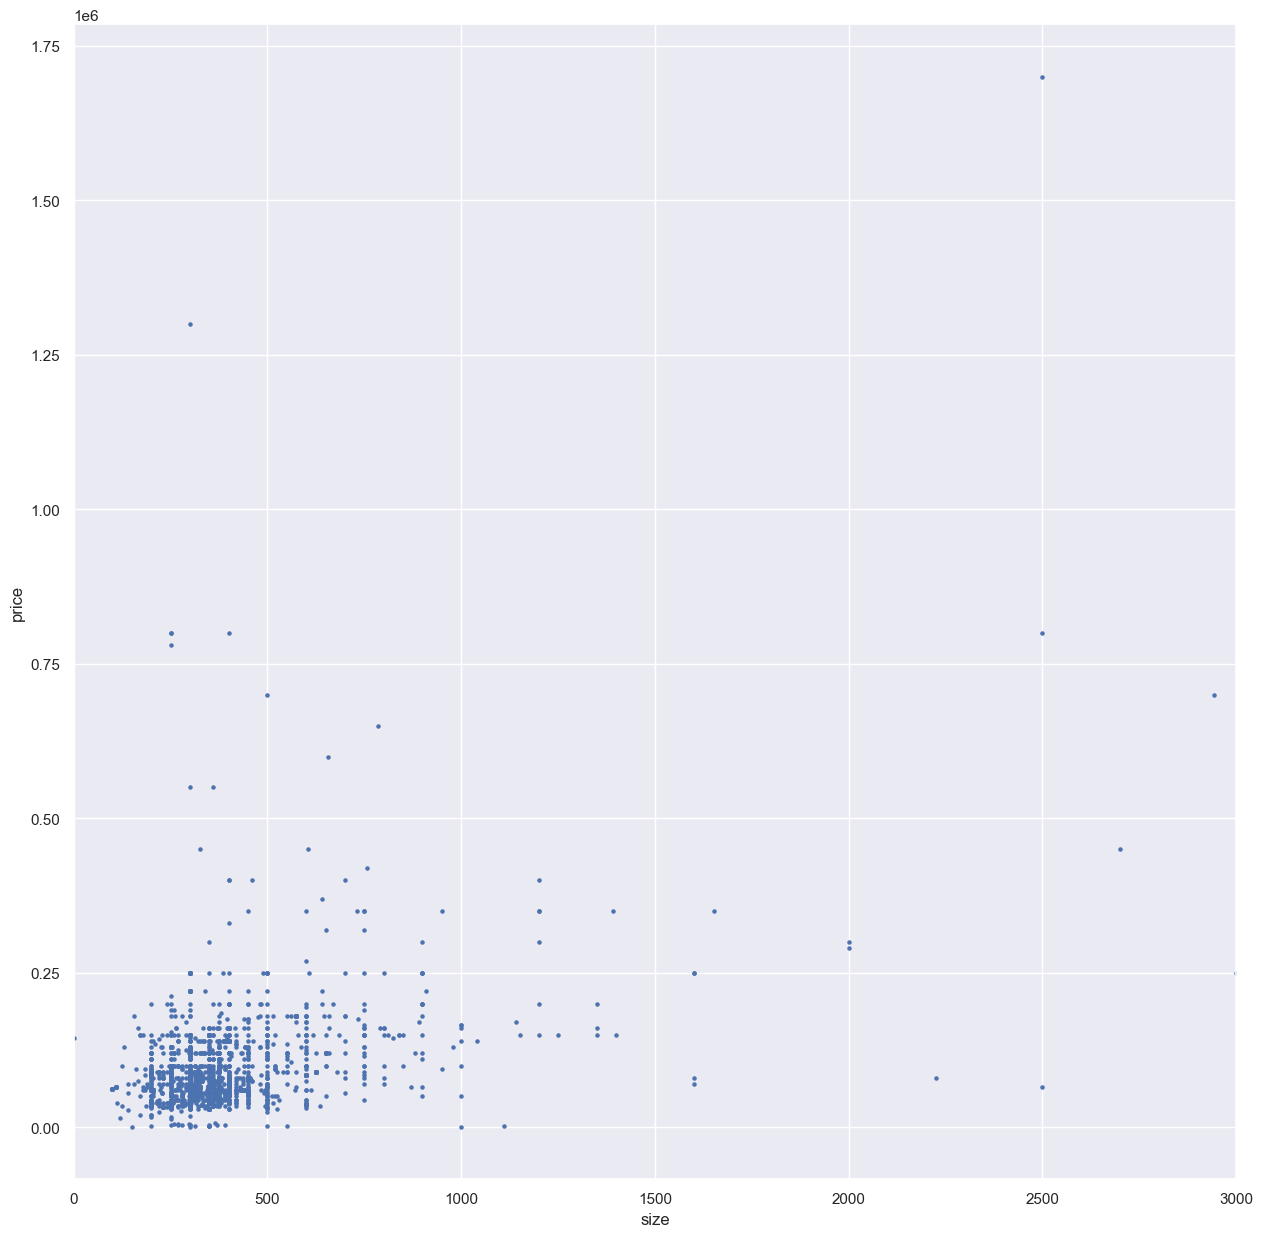

In [21]:
plt.figure(figsize=(6, 4))  
dfM2.plot(x='size', y='price', kind='scatter', xlim=(0, 3000), s=5)
plt.show()

**Property age**

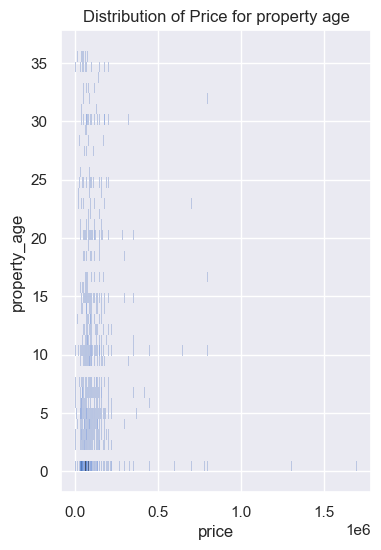

In [22]:
plt.figure(figsize=(4, 6)) 
sns.histplot(y='property_age', x='price', data=dfM2, kde=True)
plt.title('Distribution of Price for property age')
plt.show()

**Pool**

C:\Users\עתידה\AppData\Local\Temp\ipykernel_14660\2017571234.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pool', y='price', data=dfM2, palette='viridis')


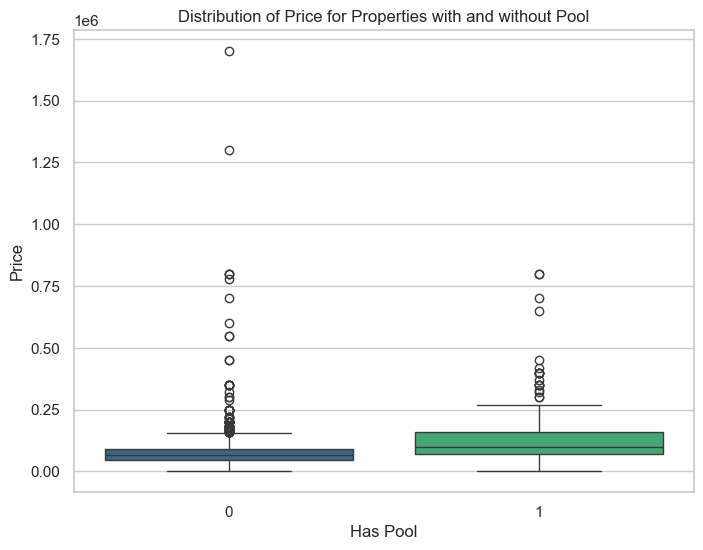

In [23]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.boxplot(x='pool', y='price', data=dfM2, palette='viridis')

plt.xlabel('Has Pool')
plt.ylabel('Price')
plt.title('Distribution of Price for Properties with and without Pool')

plt.show()

From this plot, we can infer that properties with a pool tend to have higher prices compared to properties without a pool.

**Air conditioner (ac)**

C:\Users\עתידה\AppData\Local\Temp\ipykernel_14660\658105637.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pool', y='price', data=dfM2, palette='viridis')


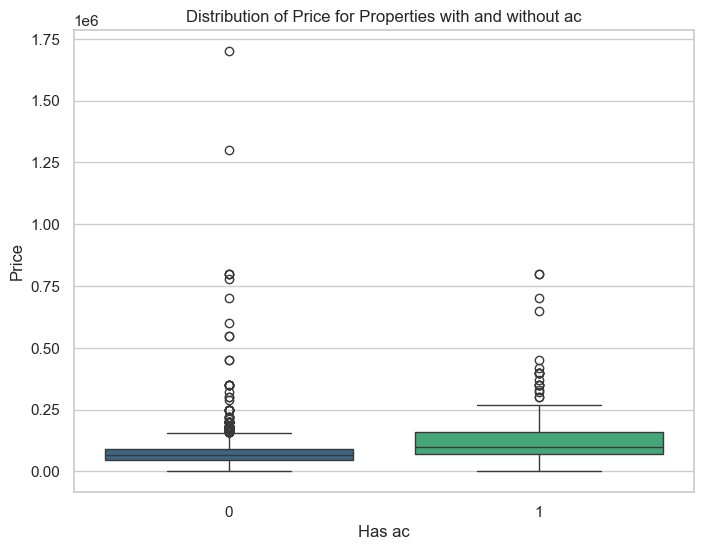

In [24]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.boxplot(x='pool', y='price', data=dfM2, palette='viridis')

plt.xlabel('Has ac')
plt.ylabel('Price')
plt.title('Distribution of Price for Properties with and without ac')

plt.show()

From this plot, we can infer that properties with an ac tend to have higher prices compared to properties without an ac.

**Bedrooms**

<Axes: xlabel='bedrooms', ylabel='price'>

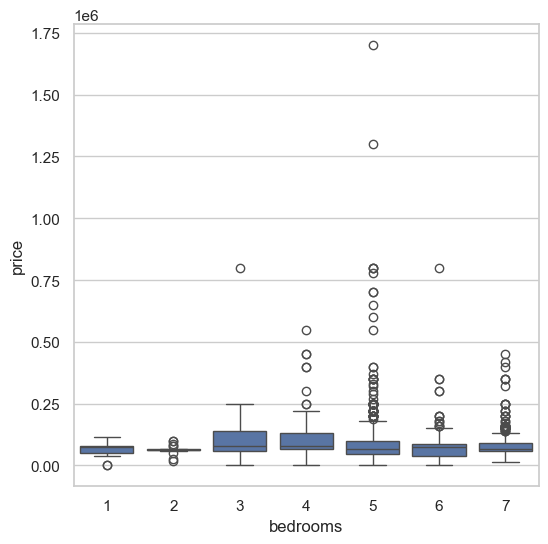

In [25]:
plt.figure(figsize=(6, 6)) 
sns.boxplot(x='bedrooms',y='price',data=dfM2)

From this plot, it appears that properties with 5 bedrooms exhibit the highest probability of being extremely expensive

**Bathrooms**

<Figure size 1000x600 with 0 Axes>

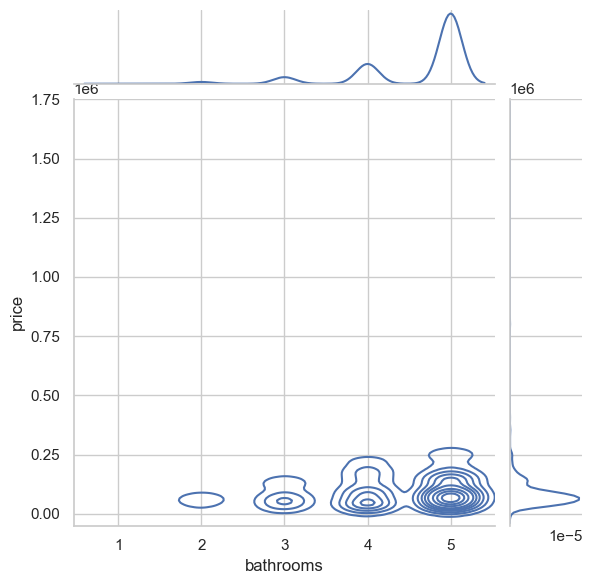

In [26]:
#comparing bathrooms and price  with kernal density estimation
plt.figure(figsize=(10,6))
sns.jointplot(x='bathrooms',y='price',data=dfM2,kind='kde')

## Outliers

## Price
We display the outliers values visually

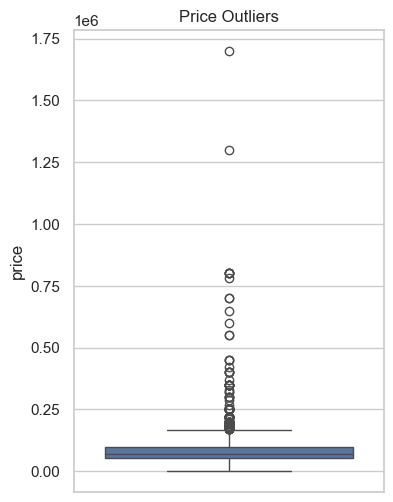

In [27]:
plt.figure(figsize=(4, 6)) 
sns.boxplot(data=dfM2,y=dfM2.price)
plt.title("Price Outliers")
plt.show()

posx and posy should be finite values


Percentage of outliers: 19.28%


posx and posy should be finite values


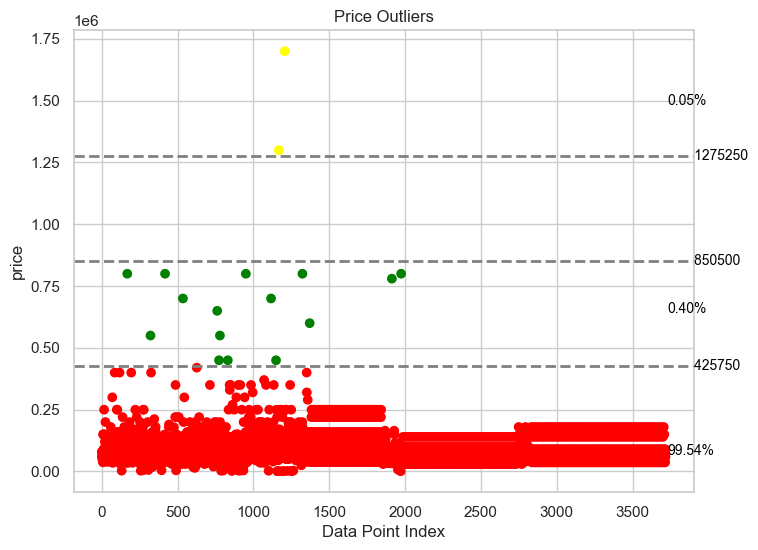

In [28]:
# Isolation Forest for outlier detection
X = dfM2[['price']]
iso_forest = IsolationForest(contamination=0.2)
outliers = iso_forest.fit_predict(X)

outlier_percentage = (sum(outliers == -1) / len(outliers)) * 100
print(f"\033[1mPercentage of outliers: {outlier_percentage:.2f}%\033[0m")

# Define color categories and boundaries
color_categories = ['red', 'green', 'blue', 'yellow']
bin_edges = pd.cut(dfM2['price'], bins=4, labels=color_categories, retbins=True)[1]

dfM2['color_category'] = pd.cut(dfM2['price'], bins=4, labels=color_categories)

plt.figure(figsize=(8, 6))
plt.scatter(x=range(len(dfM2['price'])), y=dfM2['price'], c=dfM2['color_category'])
plt.title("Price Outliers")

for idx, edge in enumerate(bin_edges[1:-1]):
    plt.axhline(edge, color='grey', linestyle='--', linewidth=2)
    
    plt.text(len(dfM2['size']) + 10, edge, f'       {int(edge)}', color='black', fontsize=10, verticalalignment='center')

plt.xlabel("Data Point Index")
plt.ylabel("price")

# Add text annotations for percentage
for category in color_categories:
    category_percentage = (sum(dfM2['color_category'] == category) / len(dfM2['color_category'])) * 100
    plt.text(len(dfM2['price']) + 10, dfM2[dfM2['color_category'] == category]['price'].mean(), 
             f'{category_percentage:.2f}%', color='black', fontsize=10, verticalalignment='center')

plt.show()


In [29]:
highest_values = dfM2['price'].nlargest(2)

# Print the count of the two highest values
print(f"Count of the two highest values: {highest_values.count()}")

Count of the two highest values: 2


We observe that the two highest values in the 'price' column exhibit a considerable magnitude compared to other outliers. As a precautionary measure to prevent potential distortions in the subsequent modeling process, we have decided to exclude these extreme values from the dataset.

In [30]:
percentile_95 = np.percentile(dfM2['price'], 95)

top_values = dfM2['price'].nlargest(2)

# Drop rows containing the two highest values
dfM2 = dfM2.drop(dfM2[dfM2['price'].isin(top_values)].index)

Now we will perform **Winsorizing**, by replacing values beyond the 95th percentile with the value at the 95th percentile. 

In [31]:
# Replace values beyond the 95th percentile with the value at the 95th percentile
dfM2.loc[dfM2['price'] > percentile_95, 'price'] = percentile_95

Display the price again

Skewness: 0.912250
Kurtosis: 0.009712


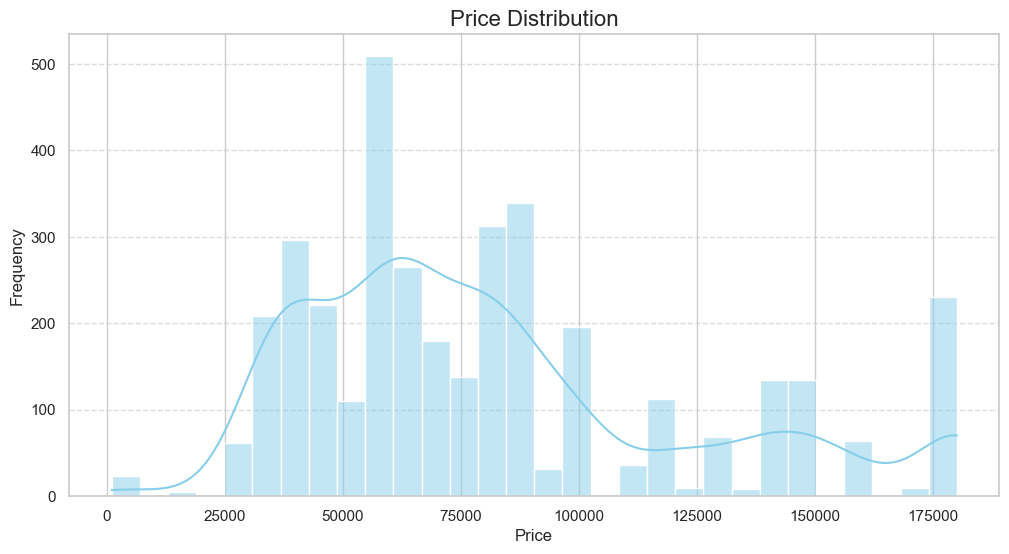

In [32]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(dfM2['price'], kde=True, color='skyblue', bins=30)
plt.title("Price Distribution", fontsize=16)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
print("\033[1mSkewness:\033[0m %f" % dfM2['price'].skew())
print("\033[1mKurtosis:\033[0m %f" % dfM2['price'].kurt())
plt.show()

  A skewness of 0.912250 suggests a right-skewed distribution (hight prices), which may deviate from normality.
    A kurtosis of 0.009712 is close to 0, indicating approximately normal tails.

## Size

In [33]:
min_size = dfM2['size'].min()
max_size = dfM2['size'].max()

print(f"The range of 'size' is very large ({min_size} - {max_size})")

The range of 'size' is very large (1 - 95000)


In addition  the Skewness(59.479436) and Kurtosis(3595.511080) values are extremely high.

Let's have a closer look on size outliers

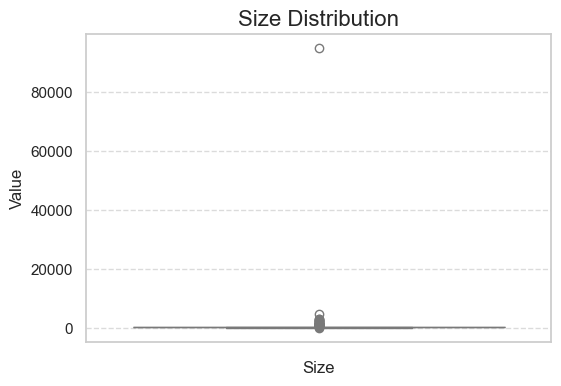

In [34]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.boxplot(data=dfM2, y='size', color='lightblue')
plt.title("Size Distribution", fontsize=16)
plt.xlabel('Size')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Outlier Scores:
[0.07788893 0.04209183 0.05612497 ... 0.05046046 0.1066955  0.01858194]
Percentage of outliers: 19.99%


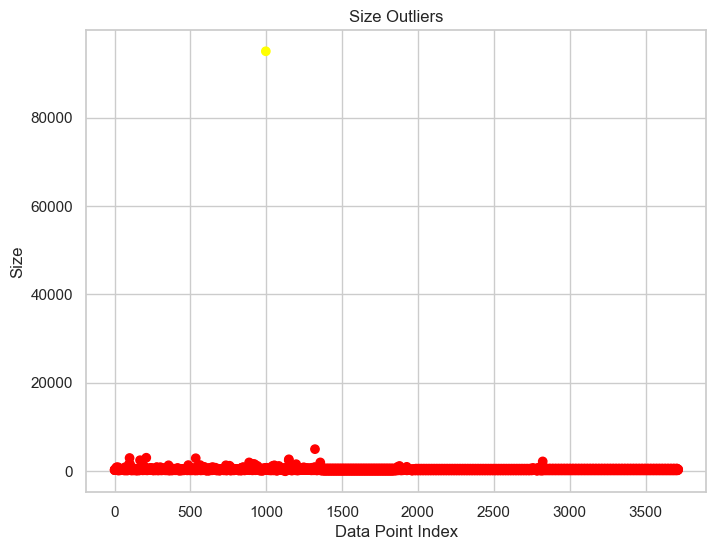

In [35]:
X = dfM2[['size']]
iso_forest = IsolationForest(contamination=0.2)
outliers = iso_forest.fit_predict(X)

outlier_scores = iso_forest.decision_function(X)

print("Outlier Scores:")
print(outlier_scores)

outlier_percentage = (sum(outliers == -1) / len(outliers)) * 100
print(f"\033[1mPercentage of outliers: {outlier_percentage:.2f}%\033[0m")

dfM2['color_category'] = pd.cut(dfM2['size'], bins=4, labels=['red', 'green', 'blue', 'yellow'])

plt.figure(figsize=(8, 6))
plt.scatter(x=range(len(dfM2['size'])), y=dfM2['size'], c=dfM2['color_category'])
plt.title("Size Outliers")
plt.xlabel("Data Point Index")
plt.ylabel("Size")
plt.show()


While analyzing the plot, we noticed a potential inconsistency between the visual representation of outliers and the calculated percentage of outliers. Despite expecting 20% outliers based on the Isolation Forest model's contamination parameter, we observed a single data point with an exceptionally high size.
So we will exclude it from the analysis and re-apply the outlier detection

Skewness: 5.774879
Kurtosis: 61.470661


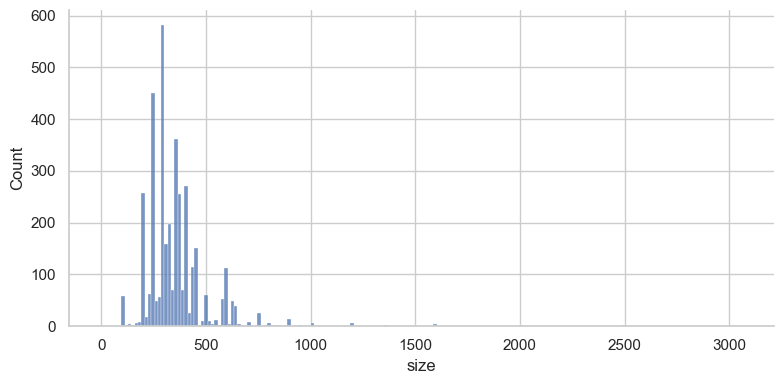

In [36]:
dfM2.drop(index= dfM2['size'].nlargest(2).index, inplace=True)
sns.displot(dfM2['size'],  height=4, aspect=2);

#skewness and kurtosis
print("Skewness: %f" % dfM2['size'].skew())
print("Kurtosis: %f" % dfM2['size'].kurt())

Percentage of outliers: 19.57%


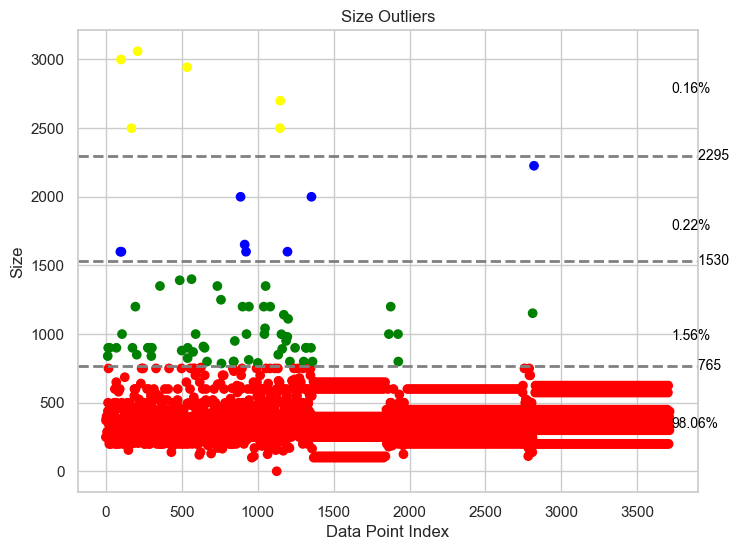

In [37]:
# Isolation Forest for outlier detection
X = dfM2[['size']]
iso_forest = IsolationForest(contamination=0.2)
outliers = iso_forest.fit_predict(X)

outlier_percentage = (sum(outliers == -1) / len(outliers)) * 100
print(f"\033[1mPercentage of outliers: {outlier_percentage:.2f}%\033[0m")

color_categories = ['red', 'green', 'blue', 'yellow']
bin_edges = pd.cut(dfM2['size'], bins=4, labels=color_categories, retbins=True)[1]

dfM2['color_category'] = pd.cut(dfM2['size'], bins=4, labels=color_categories)

plt.figure(figsize=(8, 6))
plt.scatter(x=range(len(dfM2['size'])), y=dfM2['size'], c=dfM2['color_category'])
plt.title("Size Outliers")

for idx, edge in enumerate(bin_edges[1:-1]):
    plt.axhline(edge, color='grey', linestyle='--', linewidth=2)
    
    plt.text(len(dfM2['size']) + 10, edge, f'       {int(edge)}', color='black', fontsize=10, verticalalignment='center')

plt.xlabel("Data Point Index")
plt.ylabel("Size")

for category in color_categories:
    category_percentage = (sum(dfM2['color_category'] == category) / len(dfM2['color_category'])) * 100
    plt.text(len(dfM2['size']) + 10, dfM2[dfM2['color_category'] == category]['size'].mean(), 
             f'{category_percentage:.2f}%', color='black', fontsize=10, verticalalignment='center')

plt.show()


We continue to observe a high kurtosis in the dataset, approximately 61.5. To address the anomalies related to size, we will explore three different approaches:

**Rescaling Size**
    In the first approach, we will attempt to mitigate size anomalies by rescaling the size values.

**Size Intervals Exploration**
    For the second approach, we will divide the data into size intervals and examine each interval independently. This allows us to gain insights into specific size ranges.

**Outlier Exclusion**
    The third approach involves removing rows identified as outliers. This step aims to enhance the dataset's robustness by eliminating data points considered outliers based on the chosen criteria.criteria.

# 1. Rescaling Size

In this method, we will conduct a rescaling procedure by experimenting with different thresholds that will serve as the upper limit for property sizes. Any observation exceeding this limit will be assigned a scaled size value, and the corresponding property price will be adjusted proportionally to maintain the same ratio.

### Threshold 765
The first threshold we test will be according to Isolation Forest outliers as displayed above - 765

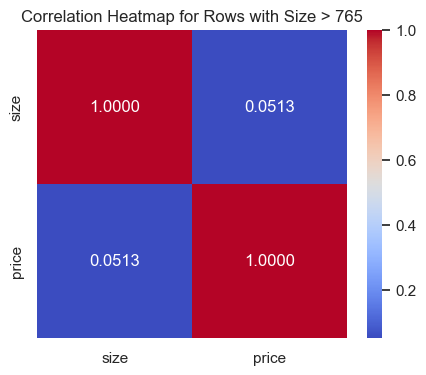

In [38]:
filtered_data = dfM2[dfM2['size'] > 765]

correlation_matrix = filtered_data[['size', 'price']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Correlation Heatmap for Rows with Size > 765")
plt.show()

The very low correlation coefficient (0.0513) suggests that the relationship between 'size > 765' and 'price' is extremely weak.

In [39]:
dfM2_1 = dfM2.copy()  # Make a copy of dfM2

In [40]:
# rescale
bound = 765

above_bound = dfM2_1[dfM2_1['size'] > bound]

min_size = above_bound['size'].min()
max_size = above_bound['size'].max()

# Rescale the sizes to the new 0-765 m² scale
pd.options.mode.chained_assignment = None  
above_bound['rescaled_size'] = (above_bound['size'] - min_size) / (max_size - min_size) * bound
pd.options.mode.chained_assignment = 'warn'  # Revert the warning state

pd.options.mode.chained_assignment = None 
above_bound['price_per_meter'] = above_bound['price'] / above_bound['size']
pd.options.mode.chained_assignment = 'warn'  # Revert the warning state

# Adjust the prices based on the new rescaled size
pd.options.mode.chained_assignment = None 
above_bound['adjusted_price'] = above_bound['rescaled_size'] * above_bound['price_per_meter']
pd.options.mode.chained_assignment = 'warn'  # Revert the warning state

above_bound = above_bound.drop(columns=['size', 'price'])

above_bound = above_bound.rename(columns={'rescaled_size': 'size', 'adjusted_price': 'price'})

above_bound.drop(columns=['price_per_meter'], inplace=True)
dfM2_1 = dfM2_1[dfM2_1['size'] <= bound]
dfM2_1 = pd.concat([dfM2_1, above_bound], ignore_index=True)


Let's see now the distribution

Skewness: 0.748514
Kurtosis: 1.323079


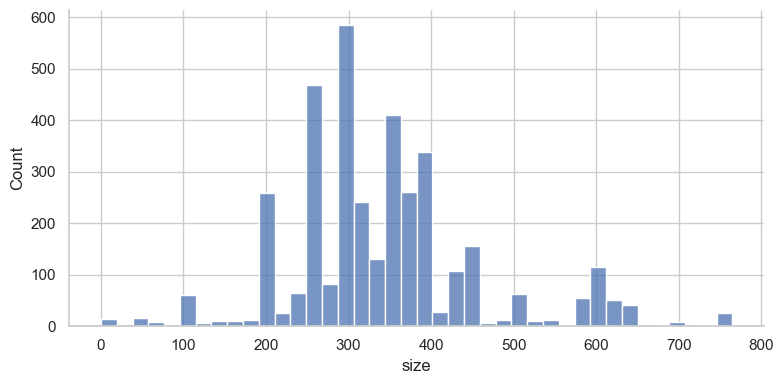

In [41]:
sns.displot(dfM2_1['size'],  height=4, aspect=2);

#skewness and kurtosis
print("Skewness: %f" % dfM2_1['size'].skew())
print("Kurtosis: %f" % dfM2_1['size'].kurt())

Now , lets see the coorelation 

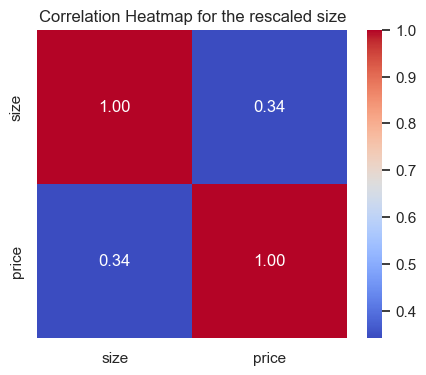

In [42]:
correlation_matrix = dfM2_1[['size', 'price']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap for the rescaled size')
plt.show()

In contrast to the pre-rescaling correlation of 0.055, it is evident that the correlation has now risen to 0.34

### Threshold 550
Now, we will explore an alternative threshold, setting it based on the distribution - 550. By setting the threshold to 550 we aim to achieve a normal distribution, where the majority of values cluster around the center, ensuring a balance in the lengths of the tails. 

In [43]:
dfM2_1_1 = dfM2.copy()  

In [44]:
bound = 550

above_bound = dfM2_1_1[dfM2_1_1['size'] > bound]

min_size = above_bound['size'].min()
max_size = above_bound['size'].max()

pd.options.mode.chained_assignment = None 
above_bound['rescaled_size'] = (above_bound['size'] - min_size) / (max_size - min_size) * bound
pd.options.mode.chained_assignment = 'warn' 

pd.options.mode.chained_assignment = None  
above_bound['price_per_meter'] = above_bound['price'] / above_bound['size']
pd.options.mode.chained_assignment = 'warn'  

pd.options.mode.chained_assignment = None  
above_bound['adjusted_price'] = above_bound['rescaled_size'] * above_bound['price_per_meter']
pd.options.mode.chained_assignment = 'warn' 

above_bound = above_bound.drop(columns=['size', 'price'])

above_bound = above_bound.rename(columns={'rescaled_size': 'size', 'adjusted_price': 'price'})

above_bound.drop(columns=['price_per_meter'], inplace=True)
dfM2_1_1 = dfM2_1_1[dfM2_1_1['size'] <= bound]
dfM2_1_1 = pd.concat([dfM2_1_1, above_bound], ignore_index=True)


Skewness: -0.874181
Kurtosis: 0.621367


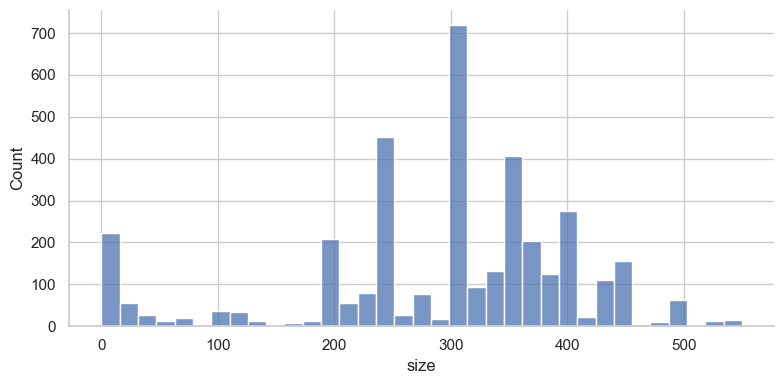

In [45]:
sns.displot(dfM2_1_1['size'],  height=4, aspect=2);

#skewness and kurtosis
print("Skewness: %f" % dfM2_1_1['size'].skew())
print("Kurtosis: %f" % dfM2_1_1['size'].kurt())

Now , lets see the coorelation 

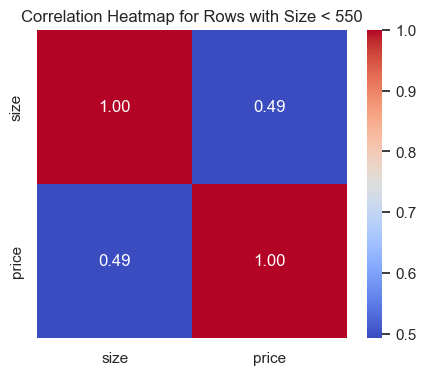

In [46]:
# Calculate the correlation matrix for the filtered data
correlation_matrix = dfM2_1_1[['size', 'price']].corr()

# Create a correlation heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap for Rows with Size < {bound}')
plt.show()

The betther correlation between size and price when we set the bound at 550 (0.49 vs 0.39), so we will go on with this   bound

In [47]:
dfM2_1 = dfM2_1_1.copy()

To make the distributions more symmetric and closer to a normal distribution we will use PowerTransformer

In [48]:
def power_transformer(df):
    columns_to_transform = df.select_dtypes(include=['number']).columns

    if len(columns_to_transform) == 0:
        print("No numerical columns to transform.")
        return df
    pt = PowerTransformer(method='box-cox')
    transformed_data = pt.fit_transform(df[columns_to_transform] + 0.000001)
    transformed_df = pd.DataFrame(transformed_data, columns=columns_to_transform, index=df.index)
    result_df = pd.concat([transformed_df, df.drop(columns=columns_to_transform)], axis=1)
    return result_df

dfM2_1 = pd.DataFrame(power_transformer(dfM2_1), columns=dfM2_1.columns)

## Correlation

<Axes: >

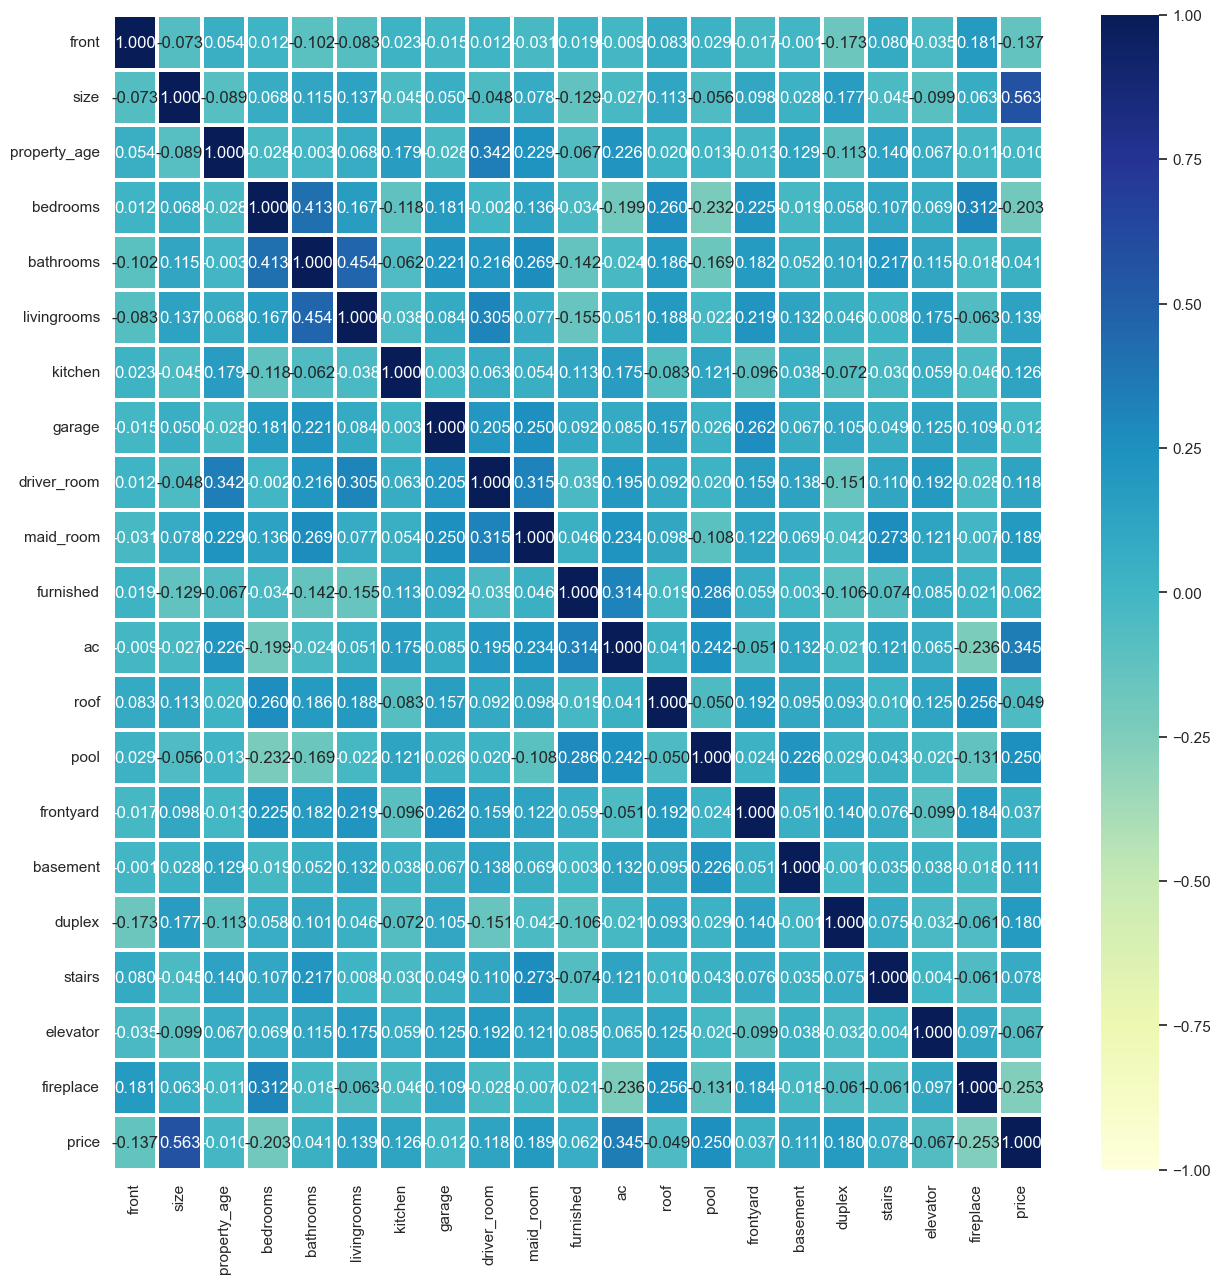

In [49]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(dfM2_1.corr(numeric_only=True), cmap='YlGnBu', annot=True, lw=1.5, fmt='.3f', vmin=-1, vmax=1)

Post-rescaling with applying a Power Transform, the correlation matrix reflects changes in the relationships among features:

Positive Correlations:
        Size maintains its positive correlation with bedrooms, bathrooms, and living rooms.
        Bedrooms and bathrooms still exhibit a positive correlation.

Negative Correlations:
        Size continues to show a negative correlation with front and furnished.
        Bedrooms and kitchen retain their negative correlation.

Noteworthy Change:
       the correlation between price and size increased.

### Correlation threshold

We established the correlation threshold based on a thorough examination of the correlation heat map. Identifying features with a low correlation to the price, we singled out the living room as the most significant among them. Given the acknowledged impact of the living room on apartment prices, we chose to define the threshold such that the correlation with the living room feature satisfies the condition. Specifically, we set the threshold at |0.13|..

In [50]:
def correlation_threshold(df):
    correlation_df = df.corr(numeric_only=True)
    threshold = 0.13
    filtered = np.abs(correlation_df['price']) >= threshold
    wanted_features = correlation_df.columns[filtered].tolist()
    
    # Unwanted features are those that do not meet the correlation threshold
    unwanted_features = correlation_df.columns[~filtered].tolist()
    
    return wanted_features, unwanted_features

wanted_features, unwanted_features = correlation_threshold(dfM2_1)
print("Wanted Features:", wanted_features)
print("Unwanted Features:", unwanted_features)

Wanted Features: ['front', 'size', 'bedrooms', 'livingrooms', 'maid_room', 'ac', 'pool', 'duplex', 'fireplace', 'price']
Unwanted Features: ['property_age', 'bathrooms', 'kitchen', 'garage', 'driver_room', 'furnished', 'roof', 'frontyard', 'basement', 'stairs', 'elevator']


In [51]:
dfM2_1 = dfM2_1.loc[:, wanted_features]

### Correlation heatmap

<Axes: >

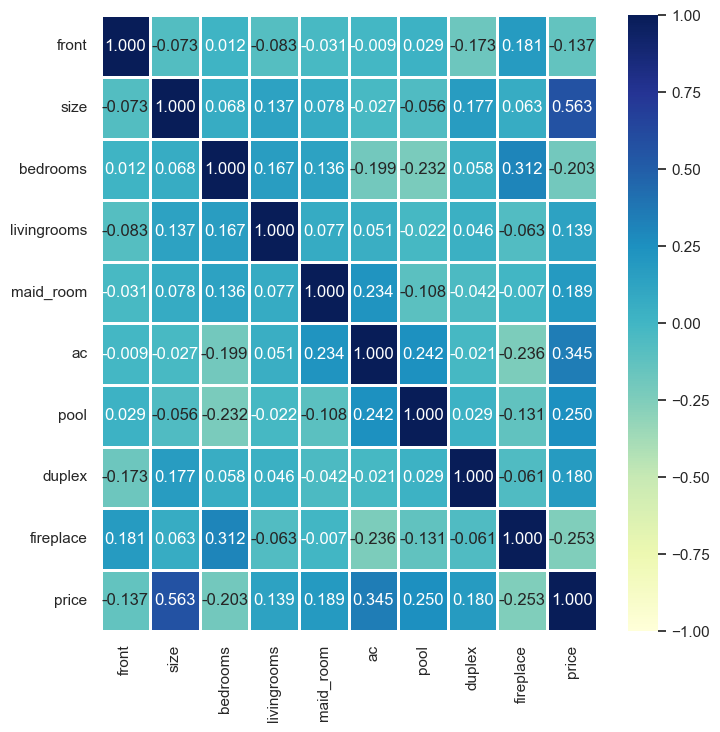

In [52]:
# heatmap of correlation among various attributes
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(dfM2_1.corr(numeric_only=True), cmap='YlGnBu', annot=True, lw=1, fmt='.3f', vmin=-1, vmax=1)

#  Implementing Algorithms -  Rescaling

In this section, we will be building different models using a variety of algorithms, and we will try and compare between them and conclude which give us the best result, which are the best for our use.


In [53]:
# Split the data for test and train sets
def split_test_train_set(data):
    x, y = data.drop('price', axis=1), data['price']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

## Regression

In [54]:
#Create a regression model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_1)
model  = LinearRegression() 
model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


**Now lets evaluating the model**

In [55]:
model_name = 'Regression - Rescaling'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

In [56]:
#print model performance
def model_performance(model_name, train_score, test_score, mae, mse, rmse):
   print(f'Model name: {model_name}')
   print("-------------------------------")
   print(f'Train score: {train_score}')
   print("-------------------------------")
   print(f'Test score: {test_score}')
   print("-------------------------------")
   print(f'Mean Absolute Error: {mae}')
   print("-------------------------------")
   print(f'Mean Squared Error: {mse}')
   print("-------------------------------")
   print(f'Root Mean Squared Error: {rmse}')

model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: Regression - Rescaling
-------------------------------
Train score: 0.552396904464409
-------------------------------
Test score: 0.5834883808720158
-------------------------------
Mean Absolute Error: 0.47849181353412007
-------------------------------
Mean Squared Error: 0.4066642994483072
-------------------------------
Root Mean Squared Error: 0.6377023596069777


In [57]:
model_fit.coef_

array([-0.05001694,  0.55762208, -0.12902355,  0.05992529,  0.12697248,
        0.21688783,  0.19378276,  0.07003899, -0.15295827])

In [58]:
comp = np.column_stack((y_test, model.predict(x_test)))
comp[:4, :]

array([[-0.47417049, -0.24115452],
       [-0.29690195, -0.12588869],
       [ 0.54322973,  0.60229711],
       [-0.68988881, -0.69450475]])

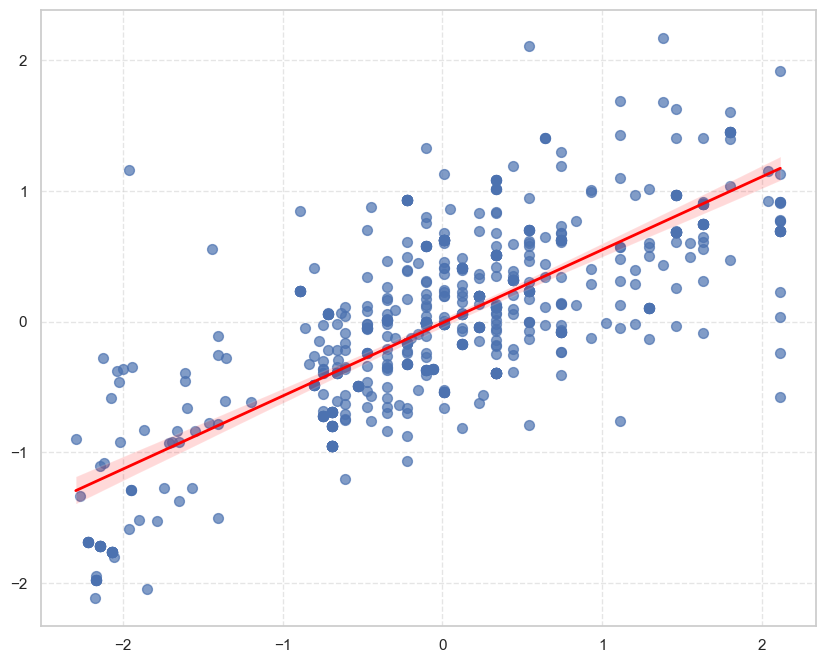

In [59]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.regplot(x=comp[:, 0], y=comp[:, 1], scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'red', 'linewidth': 2})

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Next, we will create a table where we will compare the different models that we will build

In [60]:
# Create a table to compare the performance of the different models
model_eval_data = [[model_name, train_score, test_score, mae, mse, rmse]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'MAE',
                                          'MSE', 'RMSE'])                       
evaluate_df

Model Name  Training Score  Testing Score       MAE       MSE  \
0  Regression - Rescaling        0.552397       0.583488  0.478492  0.406664   

       RMSE  
0  0.637702

## Random Forest Regressor

In [61]:
#Create the model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_1)
model  = RandomForestRegressor(n_estimators=100, random_state=42)
model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


In [62]:
model_name = 'Random Forest Regressor - Rescaling'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)


In [63]:
#print model performance
model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: Random Forest Regressor - Rescaling
-------------------------------
Train score: 0.9524244320498216
-------------------------------
Test score: 0.8094066632107464
-------------------------------
Mean Absolute Error: 0.21278258519111934
-------------------------------
Mean Squared Error: 0.18608725957558672
-------------------------------
Root Mean Squared Error: 0.4313783253428326


In [64]:
predictions = model.predict(x_test)
comp = np.column_stack((y_test,predictions))
comp[:4, :]

array([[-0.47417049, -0.45114873],
       [-0.29690195, -0.15291892],
       [ 0.54322973,  0.99388181],
       [-0.68988881, -0.68988881]])

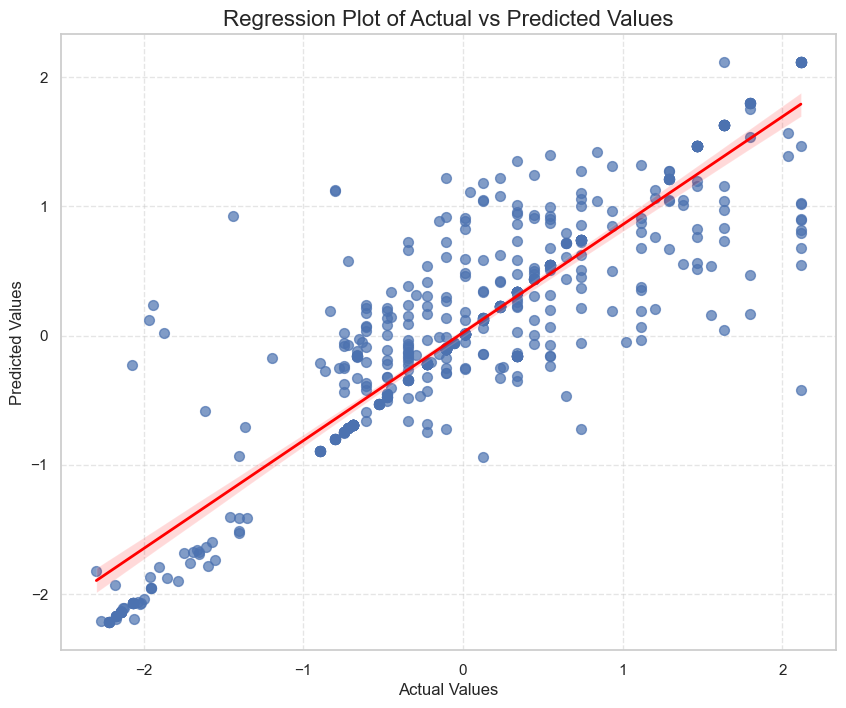

In [65]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.regplot(x=y_test, y=predictions, scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'red', 'linewidth': 2})
plt.title("Regression Plot of Actual vs Predicted Values", fontsize=16)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [66]:
# Adding to the table
model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
evaluate_df = pd.concat([evaluate_df, pd.DataFrame([model_eval_data], columns=evaluate_df.columns)], ignore_index=True)

evaluate_df

Model Name  Training Score  Testing Score  \
0               Regression - Rescaling        0.552397       0.583488   
1  Random Forest Regressor - Rescaling        0.952424       0.809407   

        MAE       MSE      RMSE  
0  0.478492  0.406664  0.637702  
1  0.212783  0.186087  0.431378

## Support Vector Machines (SVM)

In [67]:
#Create a regression model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_1)
#model  =  SVR(kernel='linear', C=1.0)
#model = SVR(kernel='poly', degree=3, C=1.0, coef0=1)
model = SVR(kernel='rbf', C=1.0, gamma='scale')


model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


In [68]:
model_name = 'SVM (rbf) - Rescaling'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

In [69]:
#print model performance
model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: SVM (rbf) - Rescaling
-------------------------------
Train score: 0.7746507176579189
-------------------------------
Test score: 0.7496910378964943
-------------------------------
Mean Absolute Error: 0.29445587656616246
-------------------------------
Mean Squared Error: 0.24439106628662102
-------------------------------
Root Mean Squared Error: 0.49435924820581745


In [70]:
# Adding to the table
model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
evaluate_df = pd.concat([evaluate_df, pd.DataFrame([model_eval_data], columns=evaluate_df.columns)], ignore_index=True)

evaluate_df

Model Name  Training Score  Testing Score  \
0               Regression - Rescaling        0.552397       0.583488   
1  Random Forest Regressor - Rescaling        0.952424       0.809407   
2                SVM (rbf) - Rescaling        0.774651       0.749691   

        MAE       MSE      RMSE  
0  0.478492  0.406664  0.637702  
1  0.212783  0.186087  0.431378  
2  0.294456  0.244391  0.494359

##  Gradient Boosting

In [71]:
#Create the model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_1)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


In [72]:
model_name = 'Gradient Boosting Regressor - Rescaling'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

In [73]:
#print model performance
model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: Gradient Boosting Regressor - Rescaling
-------------------------------
Train score: 0.7744876442782529
-------------------------------
Test score: 0.7541124311284088
-------------------------------
Mean Absolute Error: 0.32795167626060895
-------------------------------
Mean Squared Error: 0.24007420524681053
-------------------------------
Root Mean Squared Error: 0.4899736781162949


In [74]:
# Adding to the table
model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
evaluate_df = pd.concat([evaluate_df, pd.DataFrame([model_eval_data], columns=evaluate_df.columns)], ignore_index=True)

evaluate_df

Model Name  Training Score  Testing Score  \
0                   Regression - Rescaling        0.552397       0.583488   
1      Random Forest Regressor - Rescaling        0.952424       0.809407   
2                    SVM (rbf) - Rescaling        0.774651       0.749691   
3  Gradient Boosting Regressor - Rescaling        0.774488       0.754112   

        MAE       MSE      RMSE  
0  0.478492  0.406664  0.637702  
1  0.212783  0.186087  0.431378  
2  0.294456  0.244391  0.494359  
3  0.327952  0.240074  0.489974

## K-NN

In [75]:
#Create a regression model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_1)


# find the best k
k_values = np.arange(3, 21)  # Range from 3 to 20

# Perform cross-validation for each k
cv_scores = []
for k in k_values:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores))  # Negate for mean squared error

# Find the best k with the lowest mean squared error
best_k = k_values[np.argmin(cv_scores)]

print(f"Best k: {best_k}")


Best k: 8


In [76]:
# Train the final model with the best k using the full training set
model = KNeighborsRegressor(n_neighbors=best_k)
model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


In [77]:
model_name = f'K-NN k: {best_k} - Rescaling'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

In [78]:
#print model performance
model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: K-NN k: 8 - Rescaling
-------------------------------
Train score: 0.786980883391365
-------------------------------
Test score: 0.7615474981680787
-------------------------------
Mean Absolute Error: 0.232335262542358
-------------------------------
Mean Squared Error: 0.23281492077506205
-------------------------------
Root Mean Squared Error: 0.48250898517547014


In [79]:
# Adding to the table
model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
evaluate_df = pd.concat([evaluate_df, pd.DataFrame([model_eval_data], columns=evaluate_df.columns)], ignore_index=True)

evaluate_df

Model Name  Training Score  Testing Score  \
0                   Regression - Rescaling        0.552397       0.583488   
1      Random Forest Regressor - Rescaling        0.952424       0.809407   
2                    SVM (rbf) - Rescaling        0.774651       0.749691   
3  Gradient Boosting Regressor - Rescaling        0.774488       0.754112   
4                    K-NN k: 8 - Rescaling        0.786981       0.761547   

        MAE       MSE      RMSE  
0  0.478492  0.406664  0.637702  
1  0.212783  0.186087  0.431378  
2  0.294456  0.244391  0.494359  
3  0.327952  0.240074  0.489974  
4  0.232335  0.232815  0.482509

## Models Performance Analysis

In [80]:
max_testing_score_index = evaluate_df['Testing Score'].idxmax()

def highlight_max_testing(s):
    is_max = s == s.iloc[max_testing_score_index]
    return ['background-color: red' if v else '' for v in is_max]

styled_df = evaluate_df.style.apply(highlight_max_testing, subset=['Testing Score'])

styled_df.to_excel('styled_evaluate_df.xlsx', index=False) 
styled_df

**Regression**
The model has a moderate training and testing score  of approximately 0.58. The MAE is 0.48, indicating the average absolute difference between predicted and actual values. The RMSE (Root Mean Squared Error) is 0.64, representing the square root of the average squared differences between predicted and actual values.

**Random Forest Regressor**
This model has a high training score (0.95) and an excellent testing score (0.81). The MAE is impressively low at 0.21, and the RMSE is 0.43, showcasing strong predictive accuracy. However, there might be potential overfitting given the significant difference between training and testing scores.

**SVM**
The SVM model performs well with a testing score of 0.75 and a training score of 0.77. The MAE is 0.29, and the RMSE is 0.49. The model demonstrates good predictive accuracy on both sets, suggesting effective generalization.

**Gradient Boosting Regressor**
This model shows good performance with a training score of 0.77 and a testing score of 0.75. The MAE is 0.33, and the RMSE is 0.49, indicating that the model's predictions are close to the actual values.

**K-NN k: 8**
The K-NN model demonstrates strong performance with a training score of 0.79 and a testing score of 0.76. The MAE is 0.23, and the RMSE is 0.48, suggesting reasonable predictive accuracy.

**Overall Analysis**
The Random Forest Regressor stands out with the highest training and testing scores, but potential overfitting should be considered.
The SVM (RBF), Gradient Boosting Regressor, and K-NN models exhibit good balance between training and testing scores, showcasing effective     generalization.ve generalization.

In [81]:
evaluate_df_1 = evaluate_df.copy()

# 2. Size Intervals Exploration 3. Outlier Exclusionon

First we will create the models in which we will use approaches 2 and 3, in order to compare the approaches we will create models identical to the models in approach one.

# Models

In [82]:
columns=['Model Name', 'Training Score', 'Testing Score', 'MAE',
                                          'MSE', 'RMSE']

## Regression

In [83]:
def regression_model(df, model_name):
    x_train, x_test, y_train, y_test = split_test_train_set(df)
    model  = LinearRegression() 
    model_fit = model.fit(x_train, y_train)
    y_train_pred = model_fit.predict(x_train)
    y_test_pred = model_fit.predict(x_test)



    train_score = model_fit.score(x_train,y_train)
    test_score = model_fit.score(x_test,y_test)

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    
    model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
    evaluate_df =  pd.DataFrame([model_eval_data], columns= columns)
    return evaluate_df


## Random Forest Regressor

In [84]:
def random_forest_model(df, model_name):
    x_train, x_test, y_train, y_test = split_test_train_set(df)
    model  = RandomForestRegressor(n_estimators=100, random_state=42)
    model_fit = model.fit(x_train, y_train)
    y_train_pred = model_fit.predict(x_train)
    y_test_pred = model_fit.predict(x_test)



    train_score = model_fit.score(x_train,y_train)
    test_score = model_fit.score(x_test,y_test)

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    
    model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
    evaluate_df =  pd.DataFrame([model_eval_data], columns= columns)
    return evaluate_df

## Support Vector Machines (SVM)

In [85]:
def svm_model(df, model_name):
    x_train, x_test, y_train, y_test = split_test_train_set(df)
    model  = SVR(kernel='rbf', C=1.0, gamma='scale')
    model_fit = model.fit(x_train, y_train)
    y_train_pred = model_fit.predict(x_train)
    y_test_pred = model_fit.predict(x_test)



    train_score = model_fit.score(x_train,y_train)
    test_score = model_fit.score(x_test,y_test)

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    
    model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
    evaluate_df =  pd.DataFrame([model_eval_data], columns= columns)
    return evaluate_df

## Gradient Boosting

In [86]:
def gradient_boosting_model(df, model_name):
    x_train, x_test, y_train, y_test = split_test_train_set(df)
    model  =  GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model_fit = model.fit(x_train, y_train)
    y_train_pred = model_fit.predict(x_train)
    y_test_pred = model_fit.predict(x_test)



    train_score = model_fit.score(x_train,y_train)
    test_score = model_fit.score(x_test,y_test)

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    
    model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
    evaluate_df =  pd.DataFrame([model_eval_data], columns= columns)
    return evaluate_df

## K-NN

In [87]:
def knn_model(df, model_name):
      x_train, x_test, y_train, y_test = split_test_train_set(df)
    
      # find the best k
      k_values = np.arange(3, 21)  # Range from 3 to 20

      # Perform cross-validation for each k
      cv_scores = []
      for k in k_values:
          knn_regressor = KNeighborsRegressor(n_neighbors=k)
          scores = cross_val_score(knn_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
          cv_scores.append(-np.mean(scores))  # Negate for mean squared error

      # Find the best k with the lowest mean squared error
      best_k = k_values[np.argmin(cv_scores)]
      model  =  KNeighborsRegressor(n_neighbors = best_k)
      model_fit = model.fit(x_train, y_train)
      y_train_pred = model_fit.predict(x_train)
      y_test_pred = model_fit.predict(x_test)



      train_score = model_fit.score(x_train,y_train)
      test_score = model_fit.score(x_test,y_test)

      mae = mean_absolute_error(y_test, y_test_pred)
      mse = mean_squared_error(y_test, y_test_pred)
      rmse = np.sqrt(mse)
    
      model_eval_data = [f'K: {best_k} {model_name}', train_score, test_score, mae, mse, rmse]
      evaluate_df =  pd.DataFrame([model_eval_data], columns= columns)
      return evaluate_df

# 2. Size Intervals Exploration
In this approach, we will segment the size variable into 100-meter intervals and analyze each interval independently.

In [88]:
dfM2_2 = dfM2.copy()

To mitigate the impact of a long right tail we will apply **Winsorizing**. This involves substituting values ​​beyond the 95th percentile with the value at the 95th percentile.

In [89]:
# Replace values beyond the 95th percentile with the value at the 95th percentile
dfM2_2.loc[dfM2_2['size'] > percentile_95, 'size'] = percentile_95

Let's see the distribution of the size ranges

C:\Users\עתידה\AppData\Local\Temp\ipykernel_14660\2444283906.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='size_range', data=dfM2_2, palette='viridis')
C:\Users\עתידה\AppData\Local\Temp\ipykernel_14660\2444283906.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


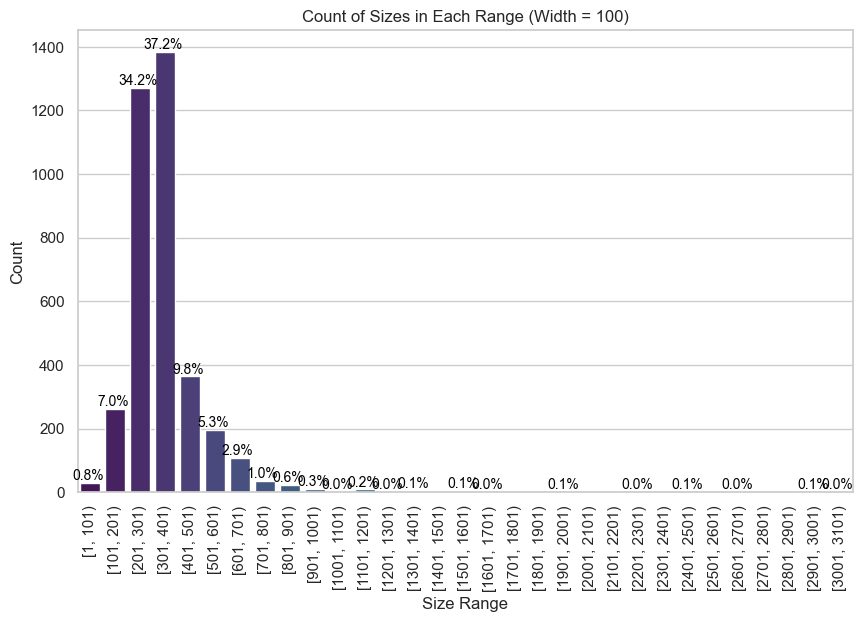

In [90]:
min_size = dfM2_2['size'].min()
max_size = dfM2_2['size'].max()

bin_width = 100
bin_edges = np.arange(min_size, max_size + bin_width, bin_width)

dfM2_2['size_range'] = pd.cut(dfM2_2['size'], bins=bin_edges, right=False)

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='size_range', data=dfM2_2, palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
total = len(dfM2_2)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10, color='black')

plt.title('Count of Sizes in Each Range (Width = 100)')
plt.xlabel('Size Range')
plt.ylabel('Count')
plt.show()

In [91]:
total_rows = len(dfM2_2)
percentage = 7
rows_for_percentage = int(percentage / 100 * total_rows)

print(f"Number of rows for {percentage}%: {rows_for_percentage}")

Number of rows for 7%: 259


A sample that is too small lacks representativeness, making it challenging to establish a reliable model. Consequently, bins with a size less than or equal to 7% (  260 rows) will merge

Let's see the distribution of the size ranges now

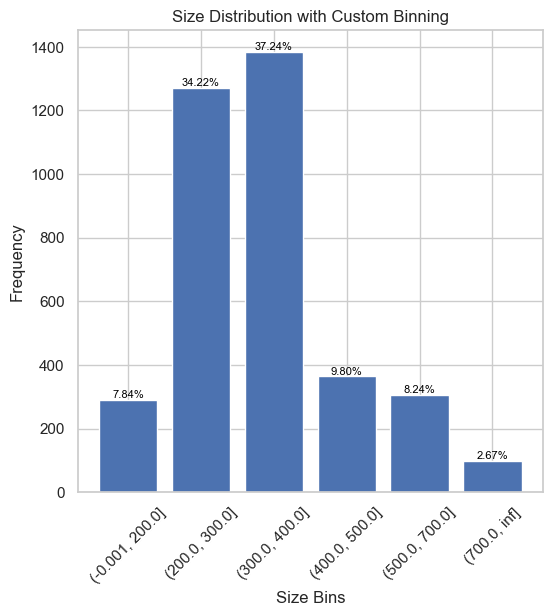

In [92]:
bin_edges = [0, 200, 300, 400, 500, 700, float('inf')]

dfM2_2['size_bins'] = pd.cut(dfM2_2['size'], bins=bin_edges, include_lowest=True)

bin_counts = dfM2_2['size_bins'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.xlabel('Size Bins')
plt.ylabel('Frequency')
plt.title('Size Distribution with Custom Binning')

plt.bar(bin_counts.index.astype(str), bin_counts.values, align='center')

plt.xticks(rotation=45)

for i, count in enumerate(bin_counts.values):
    percentage = (count / len(dfM2_2)) * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8, color='black')

plt.show()


For 700+ we don't have enough sample so we will delete them

In [93]:
dfM2_2 = dfM2_2[dfM2_2['size'] <= 700]

bin_edges = [0, 200, 300, 400, 500, 700]

# Create bins using the specified bin edges
dfM2_2['size_bins'] = pd.cut(dfM2_2['size'], bins=bin_edges, include_lowest=True)


## Correlation

C:\Users\עתידה\AppData\Local\Temp\ipykernel_14660\2356729443.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = dfM2_2.groupby('size_bins')


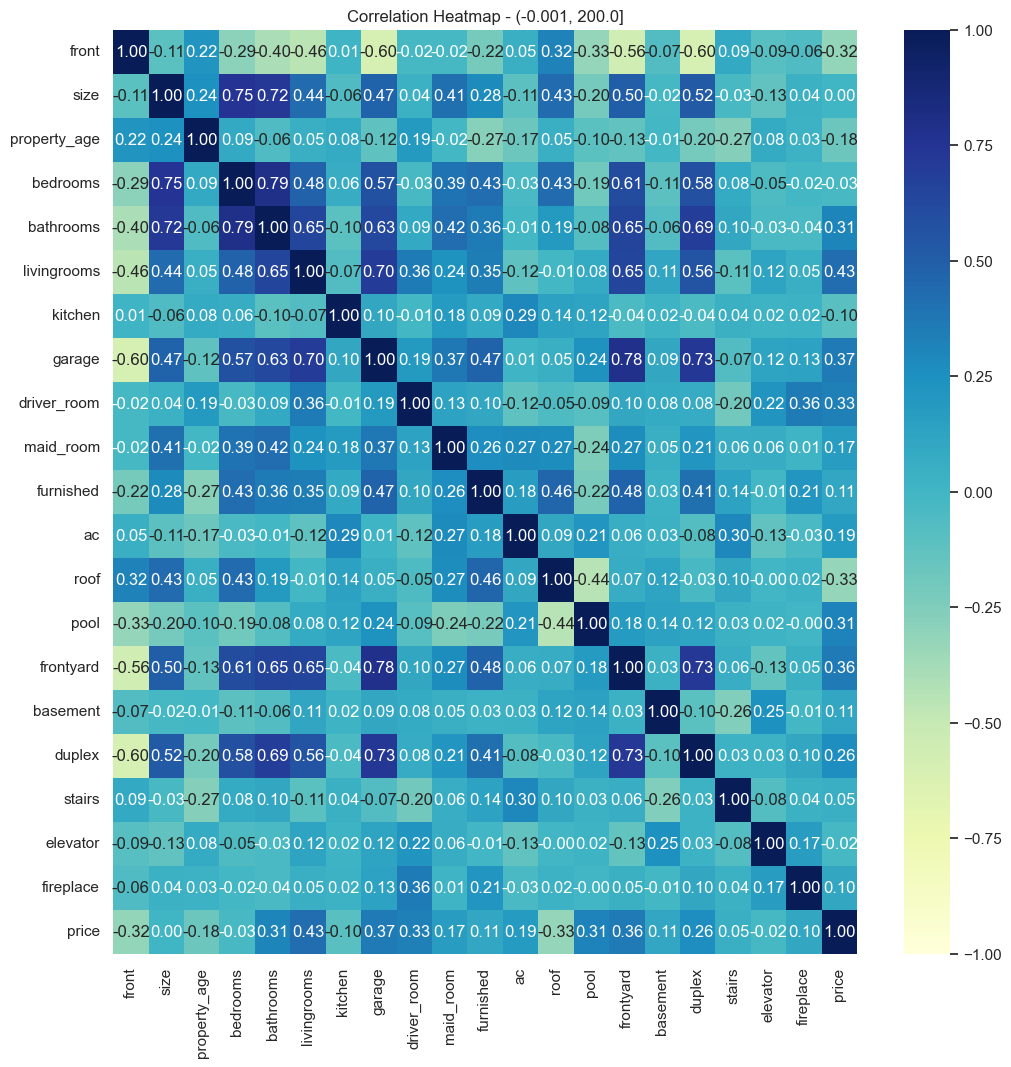

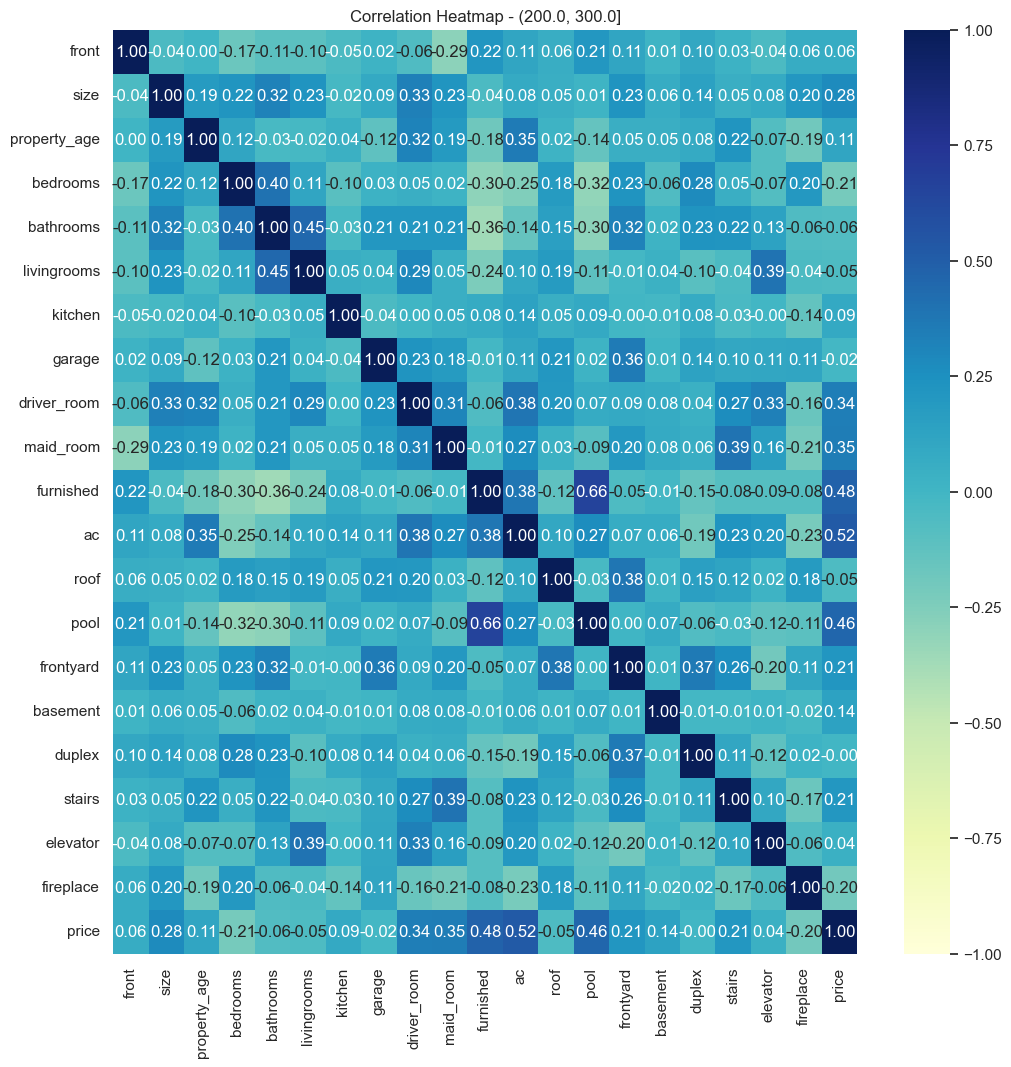

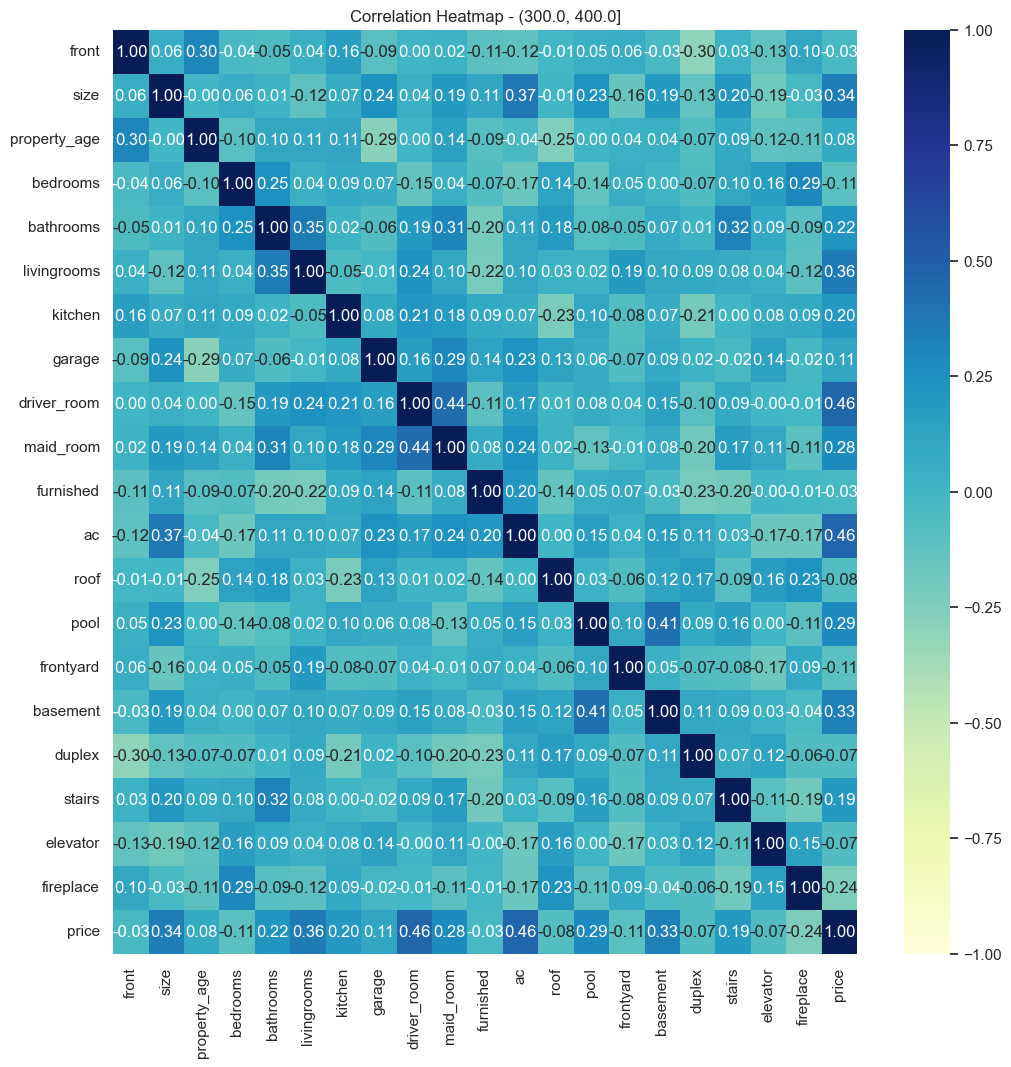

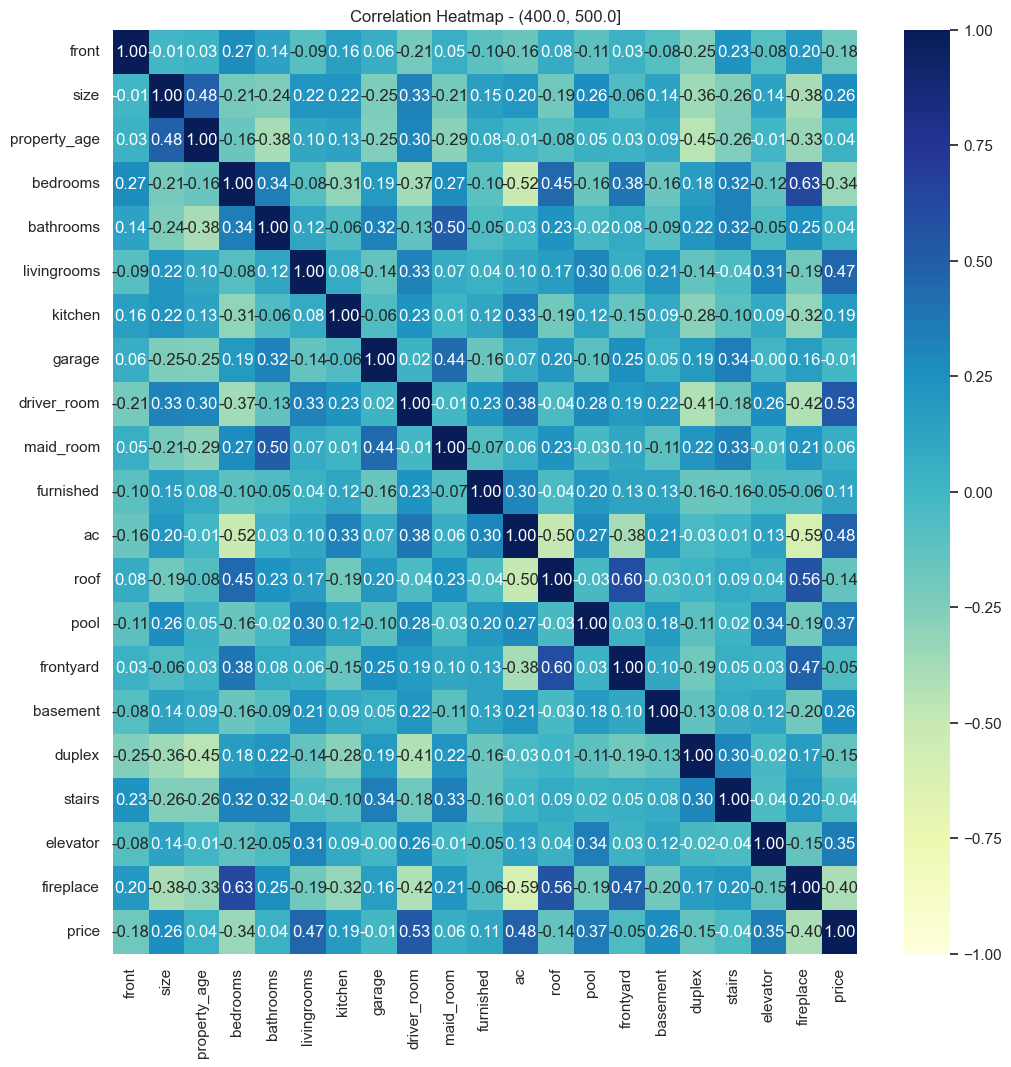

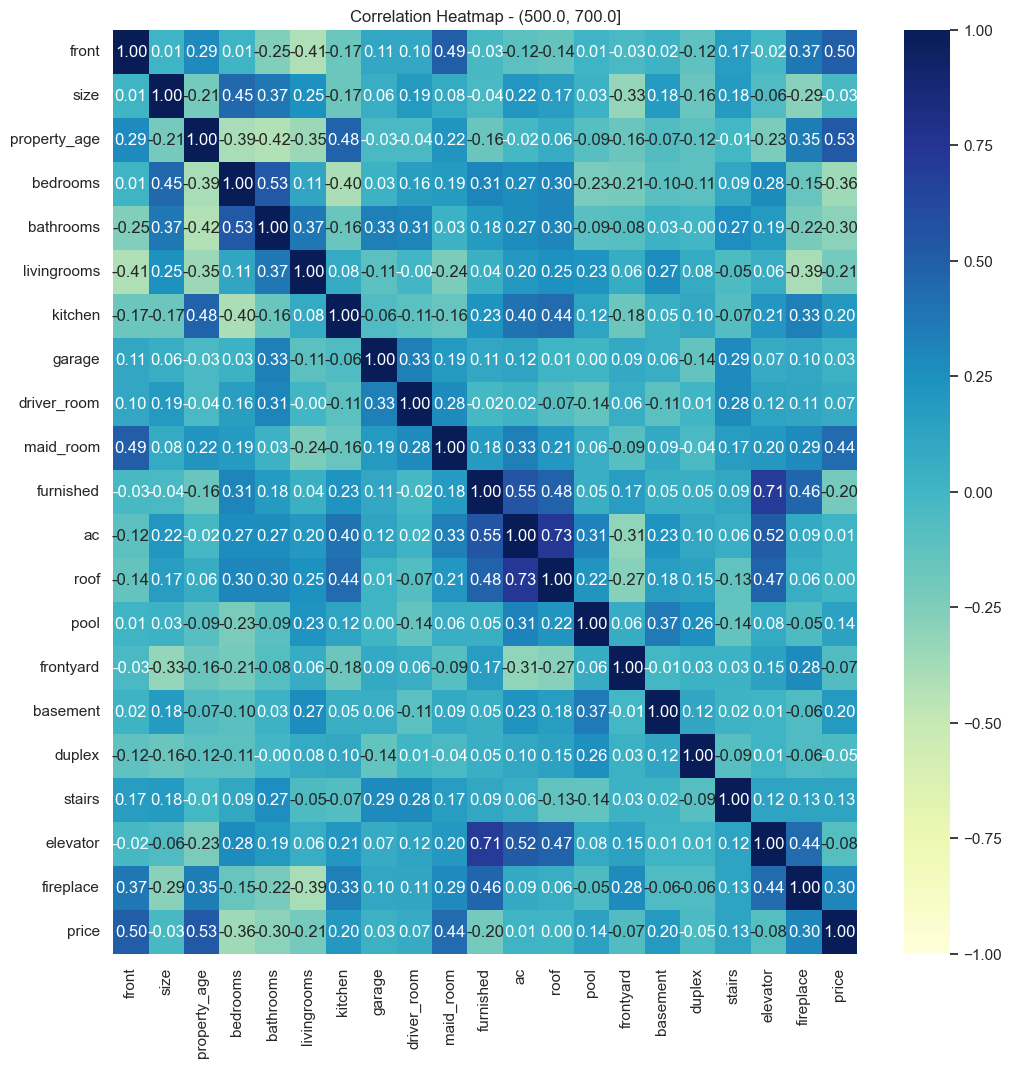

In [94]:
grouped_df = dfM2_2.groupby('size_bins')

for bin_name, group in grouped_df:
    numeric_cols = group.select_dtypes(include='number')
    
    corr_matrix = numeric_cols.corr()
    # Create a heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr_matrix, annot=True,  cmap='YlGnBu', fmt='.2f', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap - {bin_name}')
    plt.show()

Within the 0-200 range:
The correlation coefficient between size and price is nearly 0, indicating the lowest correlation. The attribute with the strongest correlation is living rooms, with a coefficient o -0.43.

In the 200-300 range:
The correlation coefficient between size and price is approximately 0.28. The attribute with the strongest correlation to price is AC, with a coefficient of -0.52.

Within the 300-400 range:
The correlation coefficient between size and price is around 0.34. The strongest correlation coefficients with price are for AC and driver room, both at about 0.46.

In the 400-500 range:
The correlation coefficient between size and price is roughly 0.26. The attribute with the strongest correlation to price is driver room, with a coeffcient of -0.53.

Within the 500-700 range:
The correlation coefficient between size and price is approximately 0.03. The strongest correlation with price is for maid room, with a cofficient of -0.44.

It's evident that within the 200-500 ranges, the correlation coefficients are relatively high, while at the edges, the correlations end to weaken.


# Modelimg

Since for each interval the correlation between the features and the price is very different, we chose to set the threshold to be the same as the threshold we used before, i.e. 0.13

At the same time create models for each range showing the results in a table

In [95]:
model_eval_data = [[0, 0, 0, 0, 0, 0]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'MAE',
                                          'MSE', 'RMSE'])                       

correlation_threshold = 0.13

for bin_name, group in grouped_df:
    # Select numerical columns for correlation calculation
    numeric_cols = group.select_dtypes(include='number')
    corr_matrix = numeric_cols.corr()

    # Filter columns based on correlation with 'price'
    correlated_columns = corr_matrix['price'].loc[abs(corr_matrix['price']) >= correlation_threshold].index
    
    # Drop columns with correlation less than |0.13|
    group_filtered = group[correlated_columns]
    
   # group_filtered = pd.DataFrame(power_transformer(group_filtered), columns=group_filtered.columns)
    # Regression
    model_name = f'Regression {bin_name}'
    model_df = regression_model(group_filtered, model_name)
    evaluate_df= pd.concat([evaluate_df, model_df], ignore_index=True)

    # Random Forest Regressor
    model_name = f'Random Forest Regressor {bin_name}'
    model_df = random_forest_model(group_filtered, model_name)
    evaluate_df= pd.concat([evaluate_df, model_df], ignore_index=True)

    # SVM
    model_name = f'SVM {bin_name}'
    model_df = svm_model(group_filtered, model_name)
    evaluate_df= pd.concat([evaluate_df, model_df], ignore_index=True)


    # Gradient Boosting
    model_name = f' Gradient Boosting {bin_name}'
    model_df = gradient_boosting_model(group_filtered, model_name)
    evaluate_df= pd.concat([evaluate_df, model_df], ignore_index=True)

    # K-NN
    model_name = f'K-NN {bin_name}'
    model_df = knn_model(group_filtered, model_name)
    evaluate_df= pd.concat([evaluate_df, model_df], ignore_index=True)


evaluate_df.drop(evaluate_df.index[0], inplace=True)




evaluate_df = evaluate_df.set_index(evaluate_df.index - 1)

def generate_light_color():
    return f'background-color: #{np.random.randint(150, 256):02X}{np.random.randint(150, 256):02X}{np.random.randint(150, 256):02X}'


def apply_styles(row, color=[generate_light_color()]):
    group_number = row.name // 5
    color_index = row.name % 5
    if color_index == 0:
        color[0] = generate_light_color()
    return [color[0]] * len(row) 

styled_df = evaluate_df.style.apply(apply_styles, axis=1)

styled_df

## Models Performance Analysis

In [96]:
def generate_light_color():
    return f'background-color: #{np.random.randint(150, 256):02X}{np.random.randint(150, 256):02X}{np.random.randint(150, 256):02X}'

def apply_styles(row, color=[generate_light_color()]):
    group_number = row.name // 5
    color_index = row.name % 5
    if color_index == 0:
        color[0] = generate_light_color()
    return [color[0]] * len(row)

def highlight_max_group(dataframe):
    max_indices = dataframe['Testing Score'].groupby(dataframe.index // 5).idxmax()
    styles = pd.DataFrame('', index=dataframe.index, columns=dataframe.columns)
    styles.loc[max_indices, 'Testing Score'] = 'background-color: red'
    return styles

styled_df = evaluate_df.style.apply(apply_styles, axis=1).apply(highlight_max_group, axis=None)

styled_df

**Interval: (0.001, 200.0]**
      Random Forest Regressor has the highest training and testing scores, indicating good predictive performance.
    SVM and Gradient Boosting show negative scores, suggesting these models may not be suitable for this interval.

**Interval: (200.0, 300.0]**    Random Forest Regressor performs well in terms of training and testing scores.
    SVM and Gradient Boosting show negative scores, suggesting potential issues with these models

**Interval: (300.0, 400.0]**
    Random Forest Regressor again demonstrates strong predictive performance.
    SVM and Gradient Boosting continue to show negative scores, indicating potential limitations

**Interval: (400.0, 500.0]**
    Random Forest Regressor remains a strong performer.
    SVM and Gradient Boosting continue to show negative scores, suggesting challenges with these models

**Interval: (500.0, 700.0]**
The Random Forest Regressor stands out as the top performer in terms of predictive accuracy.
The SVM model performs poorly, suggesting it may not be suitable for this interval.
Gradient Boosting and K-NN also show strong predictive performance, with relatively lower error values....
.

In [97]:
evaluate_df_2 = evaluate_df.copy()

# 3.Outlier Exclusion

In this approach, we will remove all rows identified as outliers.

In [98]:
dfM2_3 = dfM2.copy()

In [99]:
from sklearn.ensemble import IsolationForest

X = dfM2_3[['size']]

iso_forest = IsolationForest(contamination=0.05) 
outliers = iso_forest.fit_predict(X)

dfM2_3 = dfM2_3[outliers != -1]

Skewness: 1.023458
Kurtosis: 0.870811


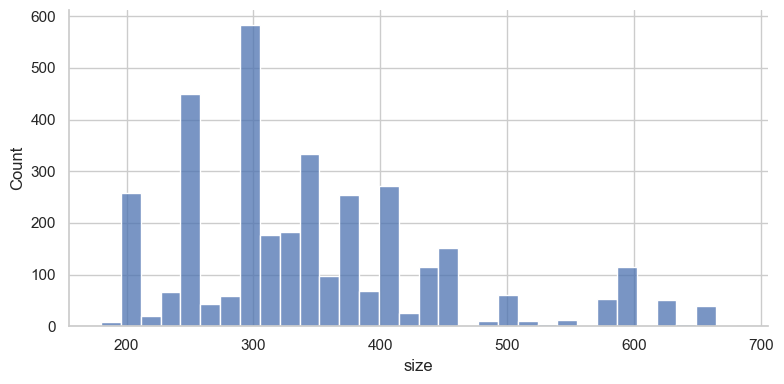

In [100]:
sns.displot(dfM2_3['size'],  height=4, aspect=2);

#skewness and kurtosis
print("Skewness: %f" % dfM2_3['size'].skew())## Correlation
print("Kurtosis: %f" % dfM2_3['size'].kurt())

## Correlation

<Axes: >

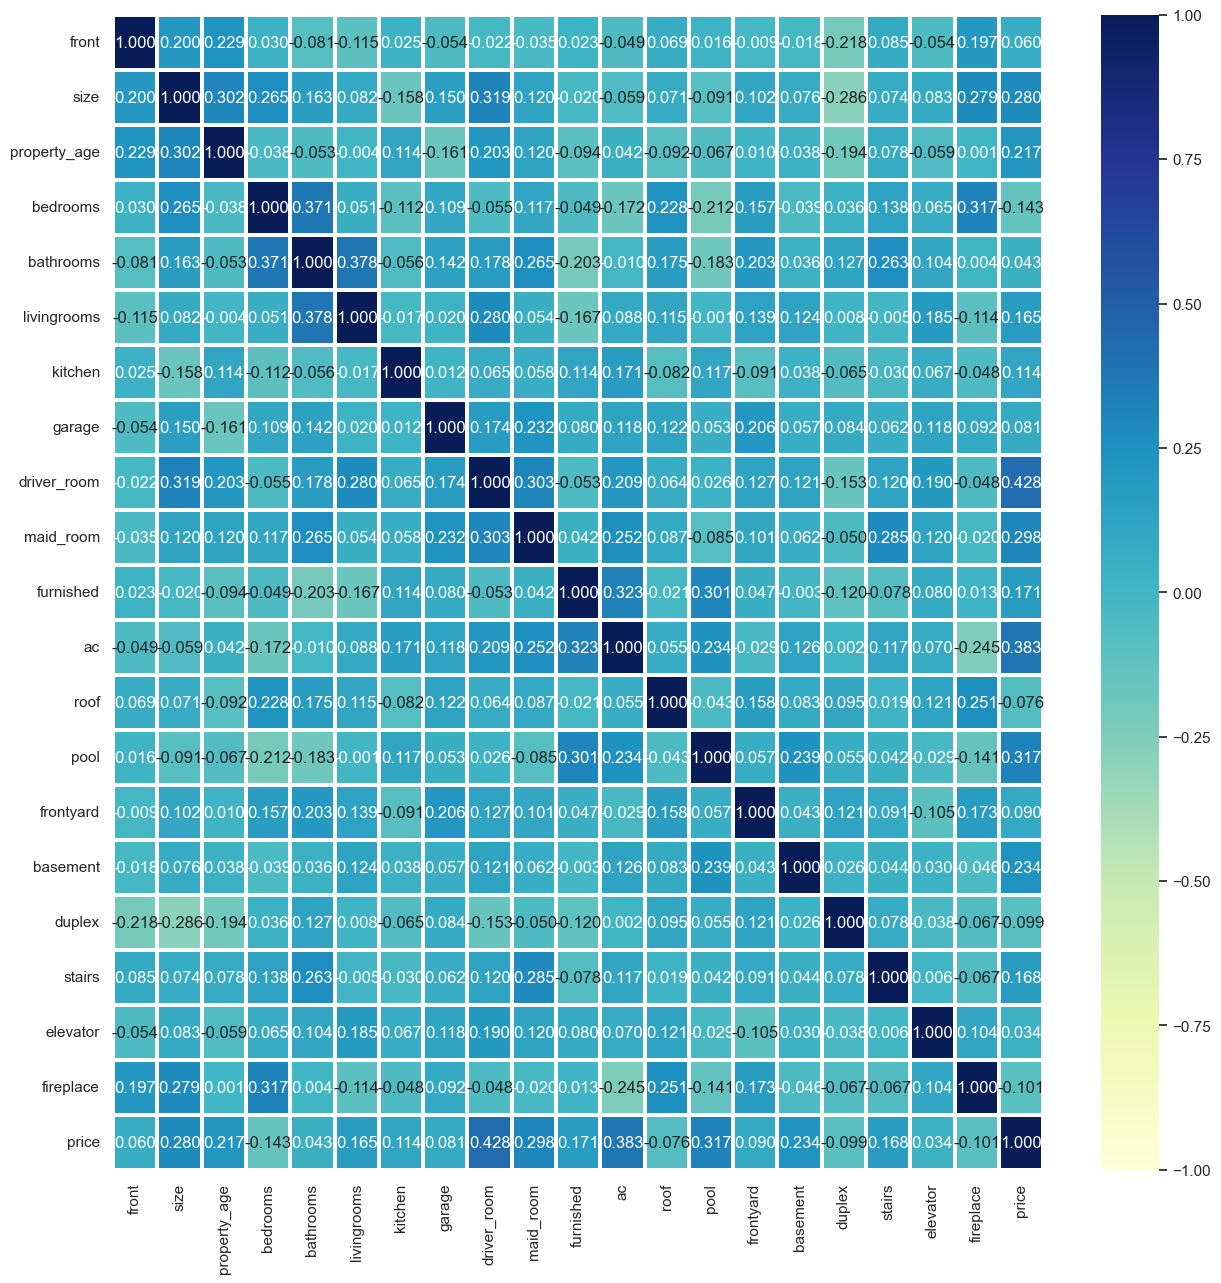

In [101]:
# heatmap of correlation among various attributes
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(dfM2_3.corr(numeric_only=True), cmap='YlGnBu', annot=True, lw=1.5, fmt='.3f', vmin=-1, vmax=1)

Since the number of bedroom is important feature we will set the threshold lower than its correlation (-0.143) other features with less than 0.14 are not such important, so due to the low correlation to price we will drop them.

In [102]:
def correlation_threshold(df):
    correlation_df = df.corr(numeric_only=True)
    threshold = 0.14
    filtered = np.abs(correlation_df['price']) >= threshold
    wanted_features = correlation_df.columns[filtered].tolist()
    
    # Unwanted features are those that do not meet the correlation threshold
    unwanted_features = correlation_df.columns[~filtered].tolist()
    
    return wanted_features, unwanted_features

wanted_features, unwanted_features = correlation_threshold(dfM2_3)
print("Wanted Features:", wanted_features)
print("Unwanted Features:", unwanted_features)

Wanted Features: ['size', 'property_age', 'bedrooms', 'livingrooms', 'driver_room', 'maid_room', 'furnished', 'ac', 'pool', 'basement', 'stairs', 'price']
Unwanted Features: ['front', 'bathrooms', 'kitchen', 'garage', 'roof', 'frontyard', 'duplex', 'elevator', 'fireplace']


In [103]:
dfM2_3 = dfM2_3.loc[:, wanted_features]

## Modeling dfM2_3

### Regression

In [104]:
#Create a regression model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_3)
model  = LinearRegression() 
model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


**Now lets evaluating the model**

In [105]:
model_name = 'Regression approach three'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

In [106]:
model_fit.coef_

array([   85.36881957,   577.04732549, -4395.84768397,  3067.35603706,
       15733.47777403, 15553.77854803,  8858.09854009, 14839.80801212,
       27549.9542879 , 20436.12920163,  7222.40877048])

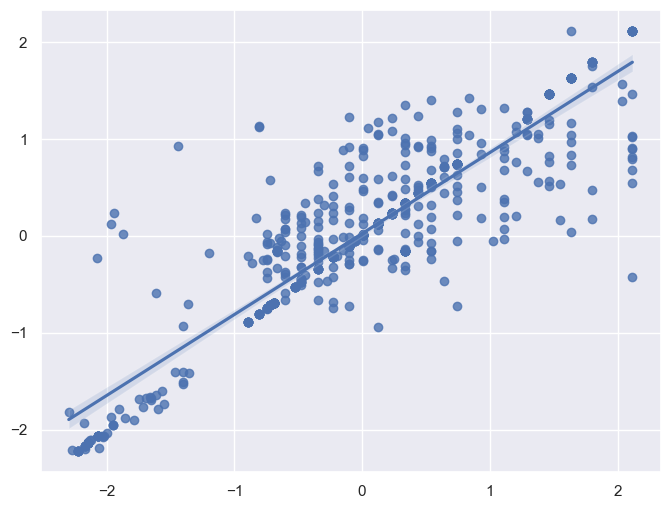

In [107]:
plt.figure(figsize=(8, 6)) 
sns.regplot(x=comp[:, 0], y=comp[:, 1])

plt.show()

In [108]:
# Create a table to compare the performance of the different models
model_eval_data = [[model_name, train_score, test_score, mae, mse, rmse]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'MAE',
                                          'MSE', 'RMSE'])                       
evaluate_df

Model Name  Training Score  Testing Score           MAE  \
0  Regression approach three        0.437882       0.414498  22779.713566   

            MSE          RMSE  
0  9.717269e+08  31172.534366

## Random Forest Regressor

In [109]:
#Create the model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_3)
model  = RandomForestRegressor(n_estimators=100, random_state=42)
model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


In [110]:
model_name = 'Random Forest Regressor approach three'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

In [111]:
#print model performance
model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: Random Forest Regressor approach three
-------------------------------
Train score: 0.9540038647684881
-------------------------------
Test score: 0.6569105668514675
-------------------------------
Mean Absolute Error: 11755.4541554992
-------------------------------
Mean Squared Error: 569407035.5117815
-------------------------------
Root Mean Squared Error: 23862.251266629926


In [112]:
predictions = model.predict(x_test)
comp = np.column_stack((y_test,predictions))
comp[:4, :]

array([[33000.        , 50323.87733333],
       [80000.        , 80000.        ],
       [45000.        , 45000.        ],
       [ 4000.        , 54180.        ]])

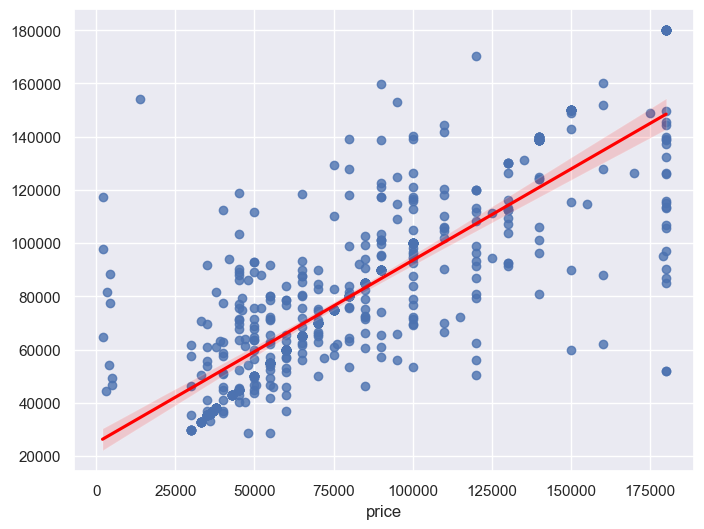

In [113]:
plt.figure(figsize=(8, 6)) 
sns.set()
sns.regplot(x=y_test, y=predictions, line_kws={'color':'red'})
plt.show()

In [114]:
# Adding to the table
model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
evaluate_df = pd.concat([evaluate_df, pd.DataFrame([model_eval_data], columns=evaluate_df.columns)], ignore_index=True)

evaluate_df

Model Name  Training Score  Testing Score  \
0               Regression approach three        0.437882       0.414498   
1  Random Forest Regressor approach three        0.954004       0.656911   

            MAE           MSE          RMSE  
0  22779.713566  9.717269e+08  31172.534366  
1  11755.454155  5.694070e+08  23862.251267

## Support Vector Machines (SVM)

In [115]:
#Create a regression model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_3)
#model  =  SVR(kernel='linear', C=1.0)
#model = SVR(kernel='poly', degree=3, C=1.0, coef0=1)
model = SVR(kernel='rbf', C=1.0, gamma='scale')


model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


In [116]:
model_name = 'SVM (rbf) approach three'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

In [117]:
#print model performance
model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: SVM (rbf) approach three
-------------------------------
Train score: -0.06971817887530096
-------------------------------
Test score: -0.05543922260737122
-------------------------------
Mean Absolute Error: 31132.501737820516
-------------------------------
Mean Squared Error: 1751655576.7765214
-------------------------------
Root Mean Squared Error: 41852.78457613688


In [118]:
# Adding to the table
model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
evaluate_df = pd.concat([evaluate_df, pd.DataFrame([model_eval_data], columns=evaluate_df.columns)], ignore_index=True)

evaluate_df

Model Name  Training Score  Testing Score  \
0               Regression approach three        0.437882       0.414498   
1  Random Forest Regressor approach three        0.954004       0.656911   
2                SVM (rbf) approach three       -0.069718      -0.055439   

            MAE           MSE          RMSE  
0  22779.713566  9.717269e+08  31172.534366  
1  11755.454155  5.694070e+08  23862.251267  
2  31132.501738  1.751656e+09  41852.784576

##  Gradient Boosting

In [119]:
#Create the model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_3)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


In [120]:
model_name = 'Gradient Boosting Regressor  approach three'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

In [121]:
#print model performance
model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: Gradient Boosting Regressor  approach three
-------------------------------
Train score: 0.7280978606282493
-------------------------------
Test score: 0.6048650748670177
-------------------------------
Mean Absolute Error: 16142.645837263011
-------------------------------
Mean Squared Error: 655784132.6746309
-------------------------------
Root Mean Squared Error: 25608.282501460944


In [122]:
# Adding to the table
model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
evaluate_df = pd.concat([evaluate_df, pd.DataFrame([model_eval_data], columns=evaluate_df.columns)], ignore_index=True)

evaluate_df

Model Name  Training Score  Testing Score  \
0                    Regression approach three        0.437882       0.414498   
1       Random Forest Regressor approach three        0.954004       0.656911   
2                     SVM (rbf) approach three       -0.069718      -0.055439   
3  Gradient Boosting Regressor  approach three        0.728098       0.604865   

            MAE           MSE          RMSE  
0  22779.713566  9.717269e+08  31172.534366  
1  11755.454155  5.694070e+08  23862.251267  
2  31132.501738  1.751656e+09  41852.784576  
3  16142.645837  6.557841e+08  25608.282501

## K-NN

In [123]:
#Create a regression model 
x_train, x_test, y_train, y_test = split_test_train_set(dfM2_3)


# find the best k
k_values = np.arange(3, 21)  # Range from 3 to 20

# Perform cross-validation for each k
cv_scores = []
for k in k_values:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores))  # Negate for mean squared error

# Find the best k with the lowest mean squared error
best_k = k_values[np.argmin(cv_scores)]

print(f"Best k: {best_k}")


Best k: 5


In [124]:
# Train the final model with the best k using the full training set
model = KNeighborsRegressor(n_neighbors=best_k)
model_fit = model.fit(x_train, y_train)
y_train_pred = model_fit.predict(x_train)
y_test_pred = model_fit.predict(x_test)
print("Model successfully created")

Model successfully created


In [125]:
model_name = f'K-NN k: {best_k}  approach three'

train_score = model_fit.score(x_train,y_train)
test_score = model_fit.score(x_test,y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

In [126]:
#print model performance
model_performance(model_name, train_score, test_score, mae, mse, rmse)

Model name: K-NN k: 5  approach three
-------------------------------
Train score: 0.7749369045982666
-------------------------------
Test score: 0.5420272499929739
-------------------------------
Mean Absolute Error: 13793.37818696884
-------------------------------
Mean Squared Error: 760072682.8966006
-------------------------------
Root Mean Squared Error: 27569.415715546107


In [127]:
# Adding to the table
model_eval_data = [model_name, train_score, test_score, mae, mse, rmse]
evaluate_df = pd.concat([evaluate_df, pd.DataFrame([model_eval_data], columns=evaluate_df.columns)], ignore_index=True)

evaluate_df

Model Name  Training Score  Testing Score  \
0                    Regression approach three        0.437882       0.414498   
1       Random Forest Regressor approach three        0.954004       0.656911   
2                     SVM (rbf) approach three       -0.069718      -0.055439   
3  Gradient Boosting Regressor  approach three        0.728098       0.604865   
4                    K-NN k: 5  approach three        0.774937       0.542027   

            MAE           MSE          RMSE  
0  22779.713566  9.717269e+08  31172.534366  
1  11755.454155  5.694070e+08  23862.251267  
2  31132.501738  1.751656e+09  41852.784576  
3  16142.645837  6.557841e+08  25608.282501  
4  13793.378187  7.600727e+08  27569.415716

In [128]:
max_testing_score_index = evaluate_df['Testing Score'].idxmax()

def highlight_testing_score_squared(s):
    is_max = s == s.iloc[max_testing_score_index]
    return ['background-color: red' if v else '' for v in is_max]

styled_df = evaluate_df.style.apply(highlight_testing_score_squared, subset=['Testing Score'])

styled_df.to_excel('styled_evaluate_df.xlsx', index=False)  # Save to an Excel file for better visualization
styled_df

In [129]:
evaluate_df_3 = evaluate_df.copy()

### Result analysis 

**Regression:**
        The model has a moderate training and testing score (R-squared) of approximately 0.43.
        The MAE (Mean Absolute Error) is 23102.84, indicating the average absolute difference between predicted and actual values.
        The RMSE (Root Mean Squared Error) is 31017.20, representing the square root of the average squared differences between predicted and actual                values.

**Random Forest Regressor:**
        This model has a high training score (0.95) but a lower testing score (0.70), suggesting potential overfitting.
        The model performs well on the testing set with a relatively low MAE and RMSE.
        It shows good predictive accuracy on the training set but may need further tuning to generalize well to new data.

**SVM:**
        The SVM model has negative scores, indicating poor performance. This might be due to the model not fitting the data well.
        The MAE, MSE, and RMSE values are relatively high, suggesting that the model predictions deviate significantly from the actual values.

**Gradient Boosting Regressor:**
        This model demonstrates good performance with a decent training and testing score (0.72 and 0.65, respectively).
        The MAE and RMSE are relatively low, indicating that the model's predictions are close to the actual values.

**K-NN (k: 6):**
        The K-NN model shows good performance with a training score of 0.75 and a testing score of 0.59.
        The model has a moderate MAE and RMSE, suggesting reasonable predictive accuracy.

### Overall Analysis:
    The Random Forest Regressor has the highest training score but might be overfitting the data.
    The Gradient Boosting Regressor and K-NN models seem to provide a good balance between training and testing scores.
    The SVM (RBF) model is not performing well based on the provided metrics and may require further analysis or parameter tuning.

In [131]:
# Conclusion

As observed, the most favorable results were achieved in approach 1. By first applying Rescaling Size with a threshold of 550, followed by PowerTransform, we substantially improved the correlation between size and price, raising it from 0.055 to 0.563. Additionally, the Random Forest Regressor attained the highest score, with a testing score of 0.809407. In comparison to other approaches, the performance metrics in this method were notably superior.

Consequently, the chosen approach will be rescaling and the chosen model for predicting apartment prices will be the Random Forest Regressor based on the success it demonstrated in this approach